In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model, Input
from tensorflow.keras import layers
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint


from tensorflow.keras.layers import LSTM, SimpleRNN, GRU
from tensorflow.keras.layers import Dense, Dropout, concatenate

from pandas import concat
from pandas import read_csv
from helper import series_to_supervised, stage_series_to_supervised

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [4]:
dataset = pd.read_csv('../data/Merged-update_hourly.csv', index_col=0)
dataset.fillna(0, inplace=True)
data = dataset
data

,WS_S1,WS_S4,FLOW_S25A,GATE_S25A,HWS_S25A,TWS_S25A,FLOW_S25B,GATE_S25B,GATE_S25B2,HWS_S25B,TWS_S25B,PUMP_S25B,FLOW_S26,GATE_S26_1,GATE_S26_2,HWS_S26,TWS_S26,PUMP_S26,MEAN_RAIN
Time,,,,,,,,,,,,,,,,,,,
1/1/10 00:00,0.33,0.34,0.0,0.0,2.17,0.49,0.0,0.0,0.0,2.84,0.58,0.0,0.00,0.0,0.00,2.78,0.505,0.0,0.0
1/1/10 01:00,-0.29,-0.28,0.0,0.0,2.17,0.02,0.0,0.0,0.0,2.84,-0.07,0.0,0.00,0.0,0.00,2.78,-0.110,0.0,0.0
1/1/10 02:00,-0.81,-0.73,0.0,0.0,2.17,-0.49,0.0,0.0,0.0,2.84,-0.62,0.0,0.00,0.0,0.00,2.79,-0.650,0.0,0.0
1/1/10 03:00,-0.98,-0.85,0.0,0.0,2.15,-0.75,0.0,0.0,0.0,2.83,-0.82,0.0,0.00,0.0,0.00,2.79,-0.850,0.0,0.0
1/1/10 04:00,-0.69,-0.49,0.0,0.0,2.13,-0.55,0.0,0.0,0.0,2.84,-0.53,0.0,0.00,0.0,0.00,2.79,-0.550,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12/31/20 19:00,1.24,1.19,0.0,0.0,1.92,1.25,0.0,0.0,0.0,2.86,1.31,0.0,456.34,0.0,2.61,2.49,1.290,0.0,0.0
12/31/20 20:00,1.62,1.61,0.0,0.0,1.92,1.64,0.0,0.0,0.0,2.88,1.68,0.0,380.19,0.0,2.62,2.48,1.660,0.0,0.0
12/31/20 21:00,1.98,1.90,0.0,0.0,1.93,2.00,0.0,0.0,0.0,2.89,2.04,0.0,287.12,0.0,2.62,2.54,2.040,0.0,0.0


In [5]:
print(dataset.columns)

Index(['WS_S1', 'WS_S4', 'FLOW_S25A', 'GATE_S25A', 'HWS_S25A', 'TWS_S25A',
       'FLOW_S25B', 'GATE_S25B', 'GATE_S25B2', 'HWS_S25B', 'TWS_S25B',
       'PUMP_S25B', 'FLOW_S26', 'GATE_S26_1', 'GATE_S26_2', 'HWS_S26',
       'TWS_S26', 'PUMP_S26', 'MEAN_RAIN'],
      dtype='object')


In [6]:
# specify the number of lag hours
n_hours = 24*3
K = 24
S = 24

### Target time series (4)
- 'WS_S1',  'TWS_S25A', 'TWS_S25B', 'TWS_S26',    
        
               
### Prior known covariates (9)
- 'WS_S4', 'GATE_S25A', 'GATE_S25B', 'GATE_S25B2', 'PUMP_S25B',  'GATE_S26_1', 'GATE_S26_2', 'PUMP_S26', 'MEAN_RAIN'


### Prior unknown covariates (6)
- 'FLOW_S25A', 'HWS_S25A', 'FLOW_S25B', 'HWS_S25B', 'FLOW_S26', 'HWS_S26'

#### Target time series: water stage (4)

In [7]:
# Pre-processing
stages = dataset[['WS_S1', 'TWS_S25A', 'TWS_S25B', 'TWS_S26']]
print("stages.shape:", stages.shape)


stages_supervised = series_to_supervised(stages, n_hours, K)
print("stages_supervised.shape:", stages_supervised.shape)

stages.shape: (96432, 4)
stages_supervised.shape: (96337, 384)


In [8]:
stages_supervised

,var1(t-72),var2(t-72),var3(t-72),var4(t-72),var1(t-71),var2(t-71),var3(t-71),var4(t-71),var1(t-70),var2(t-70),...,var3(t+21),var4(t+21),var1(t+22),var2(t+22),var3(t+22),var4(t+22),var1(t+23),var2(t+23),var3(t+23),var4(t+23)
Time,,,,,,,,,,,,,,,,,,,,,
1/4/10 00:00,0.33,0.49,0.58,0.505,-0.29,0.02,-0.07,-0.11,-0.81,-0.49,...,1.07,1.04,1.45,1.61,1.63,1.58,1.91,2.05,2.08,2.02
1/4/10 01:00,-0.29,0.02,-0.07,-0.110,-0.81,-0.49,-0.62,-0.65,-0.98,-0.75,...,1.63,1.58,1.91,2.05,2.08,2.02,2.14,2.32,2.33,2.26
1/4/10 02:00,-0.81,-0.49,-0.62,-0.650,-0.98,-0.75,-0.82,-0.85,-0.69,-0.55,...,2.08,2.02,2.14,2.32,2.33,2.26,2.07,2.28,2.29,2.23
1/4/10 03:00,-0.98,-0.75,-0.82,-0.850,-0.69,-0.55,-0.53,-0.55,0.03,0.12,...,2.33,2.26,2.07,2.28,2.29,2.23,1.55,1.78,1.78,1.72
1/4/10 04:00,-0.69,-0.55,-0.53,-0.550,0.03,0.12,0.19,0.15,0.86,0.97,...,2.29,2.23,1.55,1.78,1.78,1.72,0.85,1.08,1.05,0.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12/30/20 20:00,1.93,1.97,2.03,1.990,1.48,1.48,1.59,1.54,0.98,0.97,...,0.23,0.21,0.77,0.74,0.75,0.75,1.24,1.25,1.31,1.29
12/30/20 21:00,1.48,1.48,1.59,1.540,0.98,0.97,1.05,1.01,0.58,0.61,...,0.75,0.75,1.24,1.25,1.31,1.29,1.62,1.64,1.68,1.66
12/30/20 22:00,0.98,0.97,1.05,1.010,0.58,0.61,0.72,0.66,0.04,0.03,...,1.31,1.29,1.62,1.64,1.68,1.66,1.98,2.00,2.04,2.04


#### Prior unknown covariates (6)

In [9]:
prior_unknown = dataset[['FLOW_S25A', 'HWS_S25A', 'FLOW_S25B', 'HWS_S25B', 'FLOW_S26', 'HWS_S26' ]]
print("prior_unknown.shape:", prior_unknown.shape)

prior_unknown_supervised = series_to_supervised(prior_unknown, n_hours, S)
print("prior_unknown_supervised.shape:", prior_unknown_supervised.shape)

prior_unknown.shape: (96432, 6)
prior_unknown_supervised.shape: (96337, 576)


In [10]:
prior_unknown_supervised

,var1(t-72),var2(t-72),var3(t-72),var4(t-72),var5(t-72),var6(t-72),var1(t-71),var2(t-71),var3(t-71),var4(t-71),...,var3(t+22),var4(t+22),var5(t+22),var6(t+22),var1(t+23),var2(t+23),var3(t+23),var4(t+23),var5(t+23),var6(t+23)
Time,,,,,,,,,,,,,,,,,,,,,
1/4/10 00:00,0.0,2.17,0.00,2.84,0.00,2.78,0.0,2.17,0.00,2.84,...,0.0,2.88,0.00,2.72,0.0,2.10,0.0,2.89,0.00,2.73
1/4/10 01:00,0.0,2.17,0.00,2.84,0.00,2.78,0.0,2.17,0.00,2.84,...,0.0,2.89,0.00,2.73,0.0,2.12,0.0,2.87,0.00,2.74
1/4/10 02:00,0.0,2.17,0.00,2.84,0.00,2.79,0.0,2.15,0.00,2.83,...,0.0,2.87,0.00,2.74,0.0,2.14,0.0,2.89,0.00,2.74
1/4/10 03:00,0.0,2.15,0.00,2.83,0.00,2.79,0.0,2.13,0.00,2.84,...,0.0,2.89,0.00,2.74,0.0,2.15,0.0,2.87,0.00,2.74
1/4/10 04:00,0.0,2.13,0.00,2.84,0.00,2.79,0.0,2.12,0.00,2.84,...,0.0,2.87,0.00,2.74,0.0,2.15,0.0,2.89,0.00,2.74
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12/30/20 20:00,0.0,1.92,240.09,2.52,302.67,2.55,0.0,1.93,325.17,2.51,...,0.0,2.83,534.14,2.47,0.0,1.92,0.0,2.86,456.34,2.49
12/30/20 21:00,0.0,1.93,325.17,2.51,393.59,2.48,0.0,1.94,406.56,2.48,...,0.0,2.86,456.34,2.49,0.0,1.92,0.0,2.88,380.19,2.48
12/30/20 22:00,0.0,1.94,406.56,2.48,475.32,2.40,0.0,1.94,445.67,2.43,...,0.0,2.88,380.19,2.48,0.0,1.93,0.0,2.89,287.12,2.54


#### Prior known covariates (9)

In [11]:
prior_known = dataset[['WS_S4', 'GATE_S25A', 'GATE_S25B', 'GATE_S25B2', 'PUMP_S25B', 'GATE_S26_1', 'GATE_S26_2', 'PUMP_S26', 'MEAN_RAIN']]
print("prior_known.shape:", prior_known.shape)

prior_known_supervised = series_to_supervised(prior_known, n_hours, S)
print("prior_known_supervised.shape:", prior_known_supervised.shape)

prior_known.shape: (96432, 9)
prior_known_supervised.shape: (96337, 864)


In [12]:
prior_known_supervised

,var1(t-72),var2(t-72),var3(t-72),var4(t-72),var5(t-72),var6(t-72),var7(t-72),var8(t-72),var9(t-72),var1(t-71),...,var9(t+22),var1(t+23),var2(t+23),var3(t+23),var4(t+23),var5(t+23),var6(t+23),var7(t+23),var8(t+23),var9(t+23)
Time,,,,,,,,,,,,,,,,,,,,,
1/4/10 00:00,0.34,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.000000,-0.28,...,0.0,1.99,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
1/4/10 01:00,-0.28,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.000000,-0.73,...,0.0,2.17,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
1/4/10 02:00,-0.73,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.000000,-0.85,...,0.0,2.06,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
1/4/10 03:00,-0.85,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.000000,-0.49,...,0.0,1.50,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
1/4/10 04:00,-0.49,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.000000,0.21,...,0.0,0.86,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12/30/20 20:00,1.79,0.0,0.0,2.57,0.0,0.0,2.57,0.0,0.000000,1.31,...,0.0,1.19,0.0,0.0,0.0,0.0,0.0,2.61,0.0,0.0
12/30/20 21:00,1.31,0.0,0.0,2.57,0.0,0.0,2.57,0.0,0.000000,0.86,...,0.0,1.61,0.0,0.0,0.0,0.0,0.0,2.62,0.0,0.0
12/30/20 22:00,0.86,0.0,0.0,2.58,0.0,0.0,2.57,0.0,0.000000,0.42,...,0.0,1.90,0.0,0.0,0.0,0.0,0.0,2.62,0.0,0.0


### N_out, N_in, K

#### all past covariates in past $w$ hours

In [13]:
# 15 covariates in total
cov = dataset[['FLOW_S25A', 'HWS_S25A', 'FLOW_S25B', 'HWS_S25B', 'FLOW_S26', 'HWS_S26',\
                   'WS_S4', 'GATE_S25A', 'GATE_S25B', 'GATE_S25B2', 'PUMP_S25B', \
                    'GATE_S26_1', 'GATE_S26_2', 'PUMP_S26', 'MEAN_RAIN']]

cov_supervised = series_to_supervised(cov, n_hours, S)
print("cov_supervised.shape:", cov_supervised.shape)

cov_supervised.shape: (96337, 1440)


In [14]:
past_cov_supervised = cov_supervised.iloc[:, :n_hours*cov.shape[1]]

In [15]:
past_cov_supervised  # 6 + 9 = 15 features

,var1(t-72),var2(t-72),var3(t-72),var4(t-72),var5(t-72),var6(t-72),var7(t-72),var8(t-72),var9(t-72),var10(t-72),...,var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var11(t-1),var12(t-1),var13(t-1),var14(t-1),var15(t-1)
Time,,,,,,,,,,,,,,,,,,,,,
1/4/10 00:00,0.0,2.17,0.00,2.84,0.00,2.78,0.34,0.0,0.0,0.00,...,2.76,2.13,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0
1/4/10 01:00,0.0,2.17,0.00,2.84,0.00,2.78,-0.28,0.0,0.0,0.00,...,2.78,2.03,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0
1/4/10 02:00,0.0,2.17,0.00,2.84,0.00,2.79,-0.73,0.0,0.0,0.00,...,2.77,1.47,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0
1/4/10 03:00,0.0,2.15,0.00,2.83,0.00,2.79,-0.85,0.0,0.0,0.00,...,2.77,0.83,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0
1/4/10 04:00,0.0,2.13,0.00,2.84,0.00,2.79,-0.49,0.0,0.0,0.00,...,2.77,0.31,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12/30/20 20:00,0.0,1.92,240.09,2.52,302.67,2.55,1.79,0.0,0.0,2.57,...,2.57,1.57,0.0,0.0,2.56,0.0,0.0,2.57,0.0,0.0
12/30/20 21:00,0.0,1.93,325.17,2.51,393.59,2.48,1.31,0.0,0.0,2.57,...,2.55,1.94,0.0,0.0,2.57,0.0,0.0,2.57,0.0,0.0
12/30/20 22:00,0.0,1.94,406.56,2.48,475.32,2.40,0.86,0.0,0.0,2.58,...,2.56,2.08,0.0,0.0,2.57,0.0,0.0,2.57,0.0,0.0


#### all target water stages in past $w$ hours

In [16]:
past_ws_supervised = stages_supervised.iloc[:, :n_hours*stages.shape[1]]
past_ws_supervised.columns = ['past_ws_supervised_' + i for i in list(past_ws_supervised.columns)]

In [17]:
past_ws_supervised  # 4

,past_ws_supervised_var1(t-72),past_ws_supervised_var2(t-72),past_ws_supervised_var3(t-72),past_ws_supervised_var4(t-72),past_ws_supervised_var1(t-71),past_ws_supervised_var2(t-71),past_ws_supervised_var3(t-71),past_ws_supervised_var4(t-71),past_ws_supervised_var1(t-70),past_ws_supervised_var2(t-70),...,past_ws_supervised_var3(t-3),past_ws_supervised_var4(t-3),past_ws_supervised_var1(t-2),past_ws_supervised_var2(t-2),past_ws_supervised_var3(t-2),past_ws_supervised_var4(t-2),past_ws_supervised_var1(t-1),past_ws_supervised_var2(t-1),past_ws_supervised_var3(t-1),past_ws_supervised_var4(t-1)
Time,,,,,,,,,,,,,,,,,,,,,
1/4/10 00:00,0.33,0.49,0.58,0.505,-0.29,0.02,-0.07,-0.11,-0.81,-0.49,...,1.38,1.34,1.79,1.92,1.94,1.91,2.11,2.29,2.27,2.21
1/4/10 01:00,-0.29,0.02,-0.07,-0.110,-0.81,-0.49,-0.62,-0.65,-0.98,-0.75,...,1.94,1.91,2.11,2.29,2.27,2.21,2.07,2.27,2.26,2.22
1/4/10 02:00,-0.81,-0.49,-0.62,-0.650,-0.98,-0.75,-0.82,-0.85,-0.69,-0.55,...,2.27,2.21,2.07,2.27,2.26,2.22,1.57,1.80,1.80,1.72
1/4/10 03:00,-0.98,-0.75,-0.82,-0.850,-0.69,-0.55,-0.53,-0.55,0.03,0.12,...,2.26,2.22,1.57,1.80,1.80,1.72,0.81,1.04,1.03,0.96
1/4/10 04:00,-0.69,-0.55,-0.53,-0.550,0.03,0.12,0.19,0.15,0.86,0.97,...,1.80,1.72,0.81,1.04,1.03,0.96,0.27,0.53,0.50,0.42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12/30/20 20:00,1.93,1.97,2.03,1.990,1.48,1.48,1.59,1.54,0.98,0.97,...,0.60,0.54,1.14,1.18,1.17,1.25,1.62,1.65,1.70,1.67
12/30/20 21:00,1.48,1.48,1.59,1.540,0.98,0.97,1.05,1.01,0.58,0.61,...,1.17,1.25,1.62,1.65,1.70,1.67,1.93,1.95,2.00,2.00
12/30/20 22:00,0.98,0.97,1.05,1.010,0.58,0.61,0.72,0.66,0.04,0.03,...,1.70,1.67,1.93,1.95,2.00,2.00,2.19,2.21,2.25,2.25


#### merge all data (ws, covariates) in past $w$ hours

In [18]:
columns = []
for i in range(n_hours):
    columns = columns + past_cov_supervised.columns[i*cov.shape[1]:(i+1)*cov.shape[1]].tolist()
    columns = columns + past_ws_supervised.columns[i*stages.shape[1]:(i+1)*stages.shape[1]].tolist()
# columns

In [19]:
past_cov_supervised.reset_index(drop=True, inplace=True)
past_ws_supervised.reset_index(drop=True, inplace=True)

past_cov_ws_supervised = pd.concat([past_cov_supervised.iloc[:min(past_cov_supervised.shape[0], past_ws_supervised.shape[0]), :], 
                                    past_ws_supervised.iloc[:min(past_cov_supervised.shape[0], past_ws_supervised.shape[0]), :]], 
                                   axis=1)

past_cov_ws_supervised = past_cov_ws_supervised[columns]

In [20]:
past_cov_ws_supervised

,var1(t-72),var2(t-72),var3(t-72),var4(t-72),var5(t-72),var6(t-72),var7(t-72),var8(t-72),var9(t-72),var10(t-72),...,var10(t-1),var11(t-1),var12(t-1),var13(t-1),var14(t-1),var15(t-1),past_ws_supervised_var1(t-1),past_ws_supervised_var2(t-1),past_ws_supervised_var3(t-1),past_ws_supervised_var4(t-1)
0,0.0,2.17,0.00,2.84,0.00,2.78,0.34,0.0,0.0,0.00,...,0.00,0.0,0.0,0.00,0.0,0.0,2.11,2.29,2.27,2.21
1,0.0,2.17,0.00,2.84,0.00,2.78,-0.28,0.0,0.0,0.00,...,0.00,0.0,0.0,0.00,0.0,0.0,2.07,2.27,2.26,2.22
2,0.0,2.17,0.00,2.84,0.00,2.79,-0.73,0.0,0.0,0.00,...,0.00,0.0,0.0,0.00,0.0,0.0,1.57,1.80,1.80,1.72
3,0.0,2.15,0.00,2.83,0.00,2.79,-0.85,0.0,0.0,0.00,...,0.00,0.0,0.0,0.00,0.0,0.0,0.81,1.04,1.03,0.96
4,0.0,2.13,0.00,2.84,0.00,2.79,-0.49,0.0,0.0,0.00,...,0.00,0.0,0.0,0.00,0.0,0.0,0.27,0.53,0.50,0.42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96332,0.0,1.92,240.09,2.52,302.67,2.55,1.79,0.0,0.0,2.57,...,2.56,0.0,0.0,2.57,0.0,0.0,1.62,1.65,1.70,1.67
96333,0.0,1.93,325.17,2.51,393.59,2.48,1.31,0.0,0.0,2.57,...,2.57,0.0,0.0,2.57,0.0,0.0,1.93,1.95,2.00,2.00
96334,0.0,1.94,406.56,2.48,475.32,2.40,0.86,0.0,0.0,2.58,...,2.57,0.0,0.0,2.57,0.0,0.0,2.19,2.21,2.25,2.25
96335,0.0,1.94,445.67,2.43,519.46,2.30,0.42,0.0,0.0,2.57,...,2.57,0.0,0.0,2.57,0.0,0.0,2.11,2.12,2.22,2.19


#### shift prior known covariates in future  $S$ steps to the past

In [21]:
shift_prior_known_supervised = prior_known_supervised.iloc[:, S*prior_known.shape[1]:]
shift_prior_known_supervised.reset_index(drop=True, inplace=True)
shift_prior_known_supervised.columns = ['shift_prior_known_supervised_' + i for i in list(shift_prior_known_supervised.columns)]
shift_prior_known_supervised

,shift_prior_known_supervised_var1(t-48),shift_prior_known_supervised_var2(t-48),shift_prior_known_supervised_var3(t-48),shift_prior_known_supervised_var4(t-48),shift_prior_known_supervised_var5(t-48),shift_prior_known_supervised_var6(t-48),shift_prior_known_supervised_var7(t-48),shift_prior_known_supervised_var8(t-48),shift_prior_known_supervised_var9(t-48),shift_prior_known_supervised_var1(t-47),...,shift_prior_known_supervised_var9(t+22),shift_prior_known_supervised_var1(t+23),shift_prior_known_supervised_var2(t+23),shift_prior_known_supervised_var3(t+23),shift_prior_known_supervised_var4(t+23),shift_prior_known_supervised_var5(t+23),shift_prior_known_supervised_var6(t+23),shift_prior_known_supervised_var7(t+23),shift_prior_known_supervised_var8(t+23),shift_prior_known_supervised_var9(t+23)
0,0.60,0.0,0.0,0.00,0.0,0.0,2.61,0.0,0.0,-0.07,...,0.0,1.99,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
1,-0.07,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,-0.68,...,0.0,2.17,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
2,-0.68,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,-1.02,...,0.0,2.06,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
3,-1.02,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,-0.97,...,0.0,1.50,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
4,-0.97,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,-0.50,...,0.0,0.86,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96332,1.91,0.0,0.0,2.57,0.0,0.0,2.57,0.0,0.0,1.67,...,0.0,1.19,0.0,0.0,0.0,0.0,0.0,2.61,0.0,0.0
96333,1.67,0.0,0.0,2.57,0.0,0.0,2.57,0.0,0.0,1.16,...,0.0,1.61,0.0,0.0,0.0,0.0,0.0,2.62,0.0,0.0
96334,1.16,0.0,0.0,2.57,0.0,0.0,2.57,0.0,0.0,0.68,...,0.0,1.90,0.0,0.0,0.0,0.0,0.0,2.62,0.0,0.0
96335,0.68,0.0,0.0,2.57,0.0,0.0,2.56,0.0,0.0,0.24,...,0.0,2.03,0.0,0.0,0.0,0.0,0.0,2.62,0.0,0.0


#### merge all past data and shifted prior know future covariate

In [22]:
columns1 = []
for i in range(n_hours):
    columns1 = columns1 + past_cov_ws_supervised.columns[i*data.shape[1]:(i+1)*data.shape[1]].tolist()
    columns1 = columns1 + shift_prior_known_supervised.columns[i*prior_known.shape[1]:(i+1)*prior_known.shape[1]].tolist()
# columns

In [23]:
shift_prior_known_cov_ws_supervised = pd.concat([past_cov_ws_supervised.iloc[:min(past_cov_ws_supervised.shape[0], shift_prior_known_supervised.shape[0]), :], 
                                                 shift_prior_known_supervised.iloc[:min(past_cov_ws_supervised.shape[0], shift_prior_known_supervised.shape[0]), :]],
                                                axis=1)

shift_prior_known_cov_ws_supervised = shift_prior_known_cov_ws_supervised[columns1]

In [24]:
# shift_prior_known_cov_ws_supervised = pd.concat([past_cov_ws_supervised, shift_prior_known_supervised], 
#                                                      axis=1)

In [25]:
shift_prior_known_cov_ws_supervised

,var1(t-72),var2(t-72),var3(t-72),var4(t-72),var5(t-72),var6(t-72),var7(t-72),var8(t-72),var9(t-72),var10(t-72),...,past_ws_supervised_var4(t-1),shift_prior_known_supervised_var1(t+23),shift_prior_known_supervised_var2(t+23),shift_prior_known_supervised_var3(t+23),shift_prior_known_supervised_var4(t+23),shift_prior_known_supervised_var5(t+23),shift_prior_known_supervised_var6(t+23),shift_prior_known_supervised_var7(t+23),shift_prior_known_supervised_var8(t+23),shift_prior_known_supervised_var9(t+23)
0,0.0,2.17,0.00,2.84,0.00,2.78,0.34,0.0,0.0,0.00,...,2.21,1.99,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
1,0.0,2.17,0.00,2.84,0.00,2.78,-0.28,0.0,0.0,0.00,...,2.22,2.17,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
2,0.0,2.17,0.00,2.84,0.00,2.79,-0.73,0.0,0.0,0.00,...,1.72,2.06,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
3,0.0,2.15,0.00,2.83,0.00,2.79,-0.85,0.0,0.0,0.00,...,0.96,1.50,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
4,0.0,2.13,0.00,2.84,0.00,2.79,-0.49,0.0,0.0,0.00,...,0.42,0.86,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96332,0.0,1.92,240.09,2.52,302.67,2.55,1.79,0.0,0.0,2.57,...,1.67,1.19,0.0,0.0,0.0,0.0,0.0,2.61,0.0,0.0
96333,0.0,1.93,325.17,2.51,393.59,2.48,1.31,0.0,0.0,2.57,...,2.00,1.61,0.0,0.0,0.0,0.0,0.0,2.62,0.0,0.0
96334,0.0,1.94,406.56,2.48,475.32,2.40,0.86,0.0,0.0,2.58,...,2.25,1.90,0.0,0.0,0.0,0.0,0.0,2.62,0.0,0.0
96335,0.0,1.94,445.67,2.43,519.46,2.30,0.42,0.0,0.0,2.57,...,2.19,2.03,0.0,0.0,0.0,0.0,0.0,2.62,0.0,0.0


#### target water stage in future $k$ time steps

In [26]:
future_ws_supervised = stages_supervised.iloc[:, n_hours*stages.shape[1]:]
future_ws_supervised.reset_index(drop=True, inplace=True)
future_ws_supervised

,var1(t),var2(t),var3(t),var4(t),var1(t+1),var2(t+1),var3(t+1),var4(t+1),var1(t+2),var2(t+2),...,var3(t+21),var4(t+21),var1(t+22),var2(t+22),var3(t+22),var4(t+22),var1(t+23),var2(t+23),var3(t+23),var4(t+23)
0,2.07,2.27,2.26,2.22,1.57,1.80,1.80,1.72,0.81,1.04,...,1.07,1.04,1.45,1.61,1.63,1.58,1.91,2.05,2.08,2.02
1,1.57,1.80,1.80,1.72,0.81,1.04,1.03,0.96,0.27,0.53,...,1.63,1.58,1.91,2.05,2.08,2.02,2.14,2.32,2.33,2.26
2,0.81,1.04,1.03,0.96,0.27,0.53,0.50,0.42,-0.29,-0.02,...,2.08,2.02,2.14,2.32,2.33,2.26,2.07,2.28,2.29,2.23
3,0.27,0.53,0.50,0.42,-0.29,-0.02,-0.06,-0.14,-0.68,-0.41,...,2.33,2.26,2.07,2.28,2.29,2.23,1.55,1.78,1.78,1.72
4,-0.29,-0.02,-0.06,-0.14,-0.68,-0.41,-0.49,-0.57,-0.64,-0.46,...,2.29,2.23,1.55,1.78,1.78,1.72,0.85,1.08,1.05,0.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96332,1.93,1.95,2.00,2.00,2.19,2.21,2.25,2.25,2.11,2.12,...,0.23,0.21,0.77,0.74,0.75,0.75,1.24,1.25,1.31,1.29
96333,2.19,2.21,2.25,2.25,2.11,2.12,2.22,2.19,1.65,1.69,...,0.75,0.75,1.24,1.25,1.31,1.29,1.62,1.64,1.68,1.66
96334,2.11,2.12,2.22,2.19,1.65,1.69,1.76,1.72,1.24,1.24,...,1.31,1.29,1.62,1.64,1.68,1.66,1.98,2.00,2.04,2.04
96335,1.65,1.69,1.76,1.72,1.24,1.24,1.37,1.32,0.76,0.73,...,1.68,1.66,1.98,2.00,2.04,2.04,2.13,2.13,2.21,2.18


### Concatenation

In [27]:
all_data = concat([shift_prior_known_cov_ws_supervised, 
                   future_ws_supervised.iloc[:shift_prior_known_cov_ws_supervised.shape[0], :]], 
                  axis=1)
# print("all_data", all_data)
print("all_data.shape:", all_data.shape)

all_data.shape: (96337, 2112)


In [28]:
all_data

,var1(t-72),var2(t-72),var3(t-72),var4(t-72),var5(t-72),var6(t-72),var7(t-72),var8(t-72),var9(t-72),var10(t-72),...,var3(t+21),var4(t+21),var1(t+22),var2(t+22),var3(t+22),var4(t+22),var1(t+23),var2(t+23),var3(t+23),var4(t+23)
0,0.0,2.17,0.00,2.84,0.00,2.78,0.34,0.0,0.0,0.00,...,1.07,1.04,1.45,1.61,1.63,1.58,1.91,2.05,2.08,2.02
1,0.0,2.17,0.00,2.84,0.00,2.78,-0.28,0.0,0.0,0.00,...,1.63,1.58,1.91,2.05,2.08,2.02,2.14,2.32,2.33,2.26
2,0.0,2.17,0.00,2.84,0.00,2.79,-0.73,0.0,0.0,0.00,...,2.08,2.02,2.14,2.32,2.33,2.26,2.07,2.28,2.29,2.23
3,0.0,2.15,0.00,2.83,0.00,2.79,-0.85,0.0,0.0,0.00,...,2.33,2.26,2.07,2.28,2.29,2.23,1.55,1.78,1.78,1.72
4,0.0,2.13,0.00,2.84,0.00,2.79,-0.49,0.0,0.0,0.00,...,2.29,2.23,1.55,1.78,1.78,1.72,0.85,1.08,1.05,0.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96332,0.0,1.92,240.09,2.52,302.67,2.55,1.79,0.0,0.0,2.57,...,0.23,0.21,0.77,0.74,0.75,0.75,1.24,1.25,1.31,1.29
96333,0.0,1.93,325.17,2.51,393.59,2.48,1.31,0.0,0.0,2.57,...,0.75,0.75,1.24,1.25,1.31,1.29,1.62,1.64,1.68,1.66
96334,0.0,1.94,406.56,2.48,475.32,2.40,0.86,0.0,0.0,2.58,...,1.31,1.29,1.62,1.64,1.68,1.66,1.98,2.00,2.04,2.04
96335,0.0,1.94,445.67,2.43,519.46,2.30,0.42,0.0,0.0,2.57,...,1.68,1.66,1.98,2.00,2.04,2.04,2.13,2.13,2.21,2.18


### Train & Test set

In [29]:
all_data = all_data.values
n_train_hours = int(len(all_data)*0.8)
print("n_train_hours:", n_train_hours)


train = all_data[:n_train_hours, :]
test = all_data[n_train_hours:, :]

n_train_hours: 77069


In [30]:
n_obs = n_hours * (prior_known.shape[1]+data.shape[1])
n_obs

2016

### Normalization

In [31]:
# split into input and outputs
all_features = prior_known.shape[1] + data.shape[1]
n_obs = n_hours * all_features
train_X, train_y = train[:, :n_obs], train[:, n_obs:]
test_X, test_y = test[:, :n_obs], test[:, n_obs:]
print("train_X.shape, train_y.shape, test_X.shape, test_y.shape", train_X.shape, train_y.shape, test_X.shape, test_y.shape)


# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
train_X = scaler.fit_transform(train_X)
train_y = scaler.fit_transform(train_y)
test_X = scaler.fit_transform(test_X)
test_y = scaler.fit_transform(test_y)

train_X.shape, train_y.shape, test_X.shape, test_y.shape (77069, 2016) (77069, 96) (19268, 2016) (19268, 96)


In [32]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, all_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, all_features))
print("train_X.shape, train_y.shape, test_X.shape, test_y.shape: \n", train_X.shape, train_y.shape, test_X.shape, test_y.shape)

train_X.shape, train_y.shape, test_X.shape, test_y.shape: 
 (77069, 72, 28) (77069, 96) (19268, 72, 28) (19268, 96)


### Model

In [34]:
model_input = Input(shape=(train_X.shape[1], train_X.shape[2]))

# 3 cnn with skip connection
x1 = layers.Conv1D(filters=256, 
                    kernel_size=2, 
                    activation='relu', 
                    padding='same', 
                    kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(model_input)

x1_merge1 = concatenate([model_input, x1])

x1 = layers.Conv1D(filters=128, 
                    kernel_size=2, 
                    activation='relu', 
                    padding='same', 
                    kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(x1_merge1)

x1_merge2 = concatenate([model_input, x1])

x1 = layers.Conv1D(filters=64, 
                    kernel_size=2, 
                    activation='relu', 
                    padding='same', 
                    kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(x1_merge2)

x1_merge3 = concatenate([model_input, x1])

x1 = layers.Conv1D(filters=32, 
                    kernel_size=2, 
                    activation='relu', 
                    padding='same', 
                    kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(x1_merge3)

x1_merge4 = concatenate([model_input, x1])

x1 = layers.Conv1D(filters=16, 
                    kernel_size=2, 
                    activation='relu', 
                    padding='same', 
                    kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(x1_merge4)


# 3 rnn with skip connection
x2 = layers.SimpleRNN(128, 
                     activation='relu', 
                     return_sequences=True,
                     recurrent_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5),
                     kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(model_input)
x2_merge1 = concatenate([model_input, x2])

x2 = layers.SimpleRNN(64, 
                     activation='relu', 
                     return_sequences=True,
                     recurrent_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5),
                     kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(x2_merge1)

x2_merge2 = concatenate([model_input, x2])

x2 = layers.SimpleRNN(32, 
                     activation='relu', 
                     return_sequences=True,
                     recurrent_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5),
                     kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(x2_merge2)

x2_merge3 = concatenate([model_input, x2])

x2 = layers.SimpleRNN(16, 
                     activation='relu', 
                     return_sequences=True,
                     recurrent_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5),
                     kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(x2_merge3)

x2_merge4 = concatenate([model_input, x2])

x2 = layers.SimpleRNN(8, 
                     activation='relu', 
                     return_sequences=True,
                     recurrent_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5),
                     kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(x2_merge4)


merge = concatenate([model_input, x1, x2])
merge = layers.Flatten()(merge)
# x = Dense(256, activation='relu', kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(merge)
# x = Dense(128, activation='relu', kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(x)
# x = Dense(128, activation='relu', kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(x)
# x = Dense(64, activation='relu')(x)
x = Dense(train_y.shape[1])(merge)


ws_pararcnn = Model(model_input, x)
ws_pararcnn.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 72, 28)]     0                                            
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 72, 256)      14592       input_2[0][0]                    
__________________________________________________________________________________________________
simple_rnn_5 (SimpleRNN)        (None, 72, 128)      20096       input_2[0][0]                    
__________________________________________________________________________________________________
concatenate_9 (Concatenate)     (None, 72, 284)      0           input_2[0][0]                    
                                                                 conv1d_5[0][0]             

Epoch 1/8000


2023-01-05 23:40:10.103061: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-01-05 23:40:10.322378: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2023-01-05 23:40:11.527612: E tensorflow/stream_executor/gpu/asm_compiler.cc:110] You are using ptxas 8.x, but TF requires ptxas 9.x (and strongly prefers >= 9.2.88).  Compilation of XLA kernels below will likely fail.

You do not need to update CUDA; cherry-picking the ptxas binary is sufficient.
2023-01-05 23:40:11.927621: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 65280, output: ptxas fatal   : Value 'sm_61' is not defined for option 'gpu-name'

Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.



Epoch 00001: val_mae improved from inf to 0.06726, saving model to saved_model/ws_pararcnn_sc1_5layer_24h.h5
151/151 - 100s - loss: 0.0859 - mae: 0.0744 - val_loss: 0.0550 - val_mae: 0.0673
Epoch 2/8000

Epoch 00002: val_mae improved from 0.06726 to 0.05479, saving model to saved_model/ws_pararcnn_sc1_5layer_24h.h5
151/151 - 33s - loss: 0.0390 - mae: 0.0407 - val_loss: 0.0326 - val_mae: 0.0548
Epoch 3/8000

Epoch 00003: val_mae improved from 0.05479 to 0.04758, saving model to saved_model/ws_pararcnn_sc1_5layer_24h.h5
151/151 - 32s - loss: 0.0252 - mae: 0.0334 - val_loss: 0.0232 - val_mae: 0.0476
Epoch 4/8000

Epoch 00004: val_mae improved from 0.04758 to 0.04125, saving model to saved_model/ws_pararcnn_sc1_5layer_24h.h5
151/151 - 32s - loss: 0.0186 - mae: 0.0285 - val_loss: 0.0177 - val_mae: 0.0412
Epoch 5/8000

Epoch 00005: val_mae improved from 0.04125 to 0.03769, saving model to saved_model/ws_pararcnn_sc1_5layer_24h.h5
151/151 - 31s - loss: 0.0145 - mae: 0.0249 - val_loss: 0.0142

Epoch 45/8000

Epoch 00045: val_mae improved from 0.01683 to 0.01622, saving model to saved_model/ws_pararcnn_sc1_5layer_24h.h5
151/151 - 33s - loss: 3.1148e-04 - mae: 0.0091 - val_loss: 5.8506e-04 - val_mae: 0.0162
Epoch 46/8000

Epoch 00046: val_mae did not improve from 0.01622
151/151 - 32s - loss: 3.0823e-04 - mae: 0.0091 - val_loss: 6.2791e-04 - val_mae: 0.0168
Epoch 47/8000

Epoch 00047: val_mae did not improve from 0.01622
151/151 - 32s - loss: 3.0144e-04 - mae: 0.0090 - val_loss: 5.9019e-04 - val_mae: 0.0164
Epoch 48/8000

Epoch 00048: val_mae did not improve from 0.01622
151/151 - 32s - loss: 2.9874e-04 - mae: 0.0090 - val_loss: 6.1888e-04 - val_mae: 0.0167
Epoch 49/8000

Epoch 00049: val_mae did not improve from 0.01622
151/151 - 32s - loss: 2.9397e-04 - mae: 0.0089 - val_loss: 7.3755e-04 - val_mae: 0.0188
Epoch 50/8000

Epoch 00050: val_mae did not improve from 0.01622
151/151 - 32s - loss: 2.9240e-04 - mae: 0.0090 - val_loss: 6.3849e-04 - val_mae: 0.0174
Epoch 51/8000

Epoc

Epoch 96/8000

Epoch 00096: val_mae did not improve from 0.01423
151/151 - 32s - loss: 2.5586e-04 - mae: 0.0083 - val_loss: 5.6774e-04 - val_mae: 0.0164
Epoch 97/8000

Epoch 00097: val_mae did not improve from 0.01423
151/151 - 32s - loss: 2.5380e-04 - mae: 0.0082 - val_loss: 4.7371e-04 - val_mae: 0.0146
Epoch 98/8000

Epoch 00098: val_mae did not improve from 0.01423
151/151 - 32s - loss: 2.5360e-04 - mae: 0.0082 - val_loss: 5.0931e-04 - val_mae: 0.0152
Epoch 99/8000

Epoch 00099: val_mae did not improve from 0.01423
151/151 - 32s - loss: 2.5021e-04 - mae: 0.0081 - val_loss: 4.7283e-04 - val_mae: 0.0144
Epoch 100/8000

Epoch 00100: val_mae improved from 0.01423 to 0.01403, saving model to saved_model/ws_pararcnn_sc1_5layer_24h.h5
151/151 - 32s - loss: 2.5066e-04 - mae: 0.0081 - val_loss: 4.4220e-04 - val_mae: 0.0140
Epoch 101/8000

Epoch 00101: val_mae did not improve from 0.01403
151/151 - 32s - loss: 2.5224e-04 - mae: 0.0082 - val_loss: 5.2368e-04 - val_mae: 0.0155
Epoch 102/8000

E

Epoch 148/8000

Epoch 00148: val_mae did not improve from 0.01353
151/151 - 32s - loss: 2.4106e-04 - mae: 0.0079 - val_loss: 4.9414e-04 - val_mae: 0.0147
Epoch 149/8000

Epoch 00149: val_mae did not improve from 0.01353
151/151 - 33s - loss: 2.3857e-04 - mae: 0.0078 - val_loss: 4.9213e-04 - val_mae: 0.0149
Epoch 150/8000

Epoch 00150: val_mae did not improve from 0.01353
151/151 - 32s - loss: 2.4195e-04 - mae: 0.0079 - val_loss: 4.8799e-04 - val_mae: 0.0147
Epoch 151/8000

Epoch 00151: val_mae did not improve from 0.01353
151/151 - 32s - loss: 2.4190e-04 - mae: 0.0079 - val_loss: 5.2243e-04 - val_mae: 0.0157
Epoch 152/8000

Epoch 00152: val_mae did not improve from 0.01353
151/151 - 32s - loss: 2.4047e-04 - mae: 0.0079 - val_loss: 5.0859e-04 - val_mae: 0.0155
Epoch 153/8000

Epoch 00153: val_mae improved from 0.01353 to 0.01317, saving model to saved_model/ws_pararcnn_sc1_5layer_24h.h5
151/151 - 32s - loss: 2.3881e-04 - mae: 0.0078 - val_loss: 3.9863e-04 - val_mae: 0.0132
Epoch 154/800

Epoch 200/8000

Epoch 00200: val_mae did not improve from 0.01284
151/151 - 32s - loss: 2.3363e-04 - mae: 0.0077 - val_loss: 4.1282e-04 - val_mae: 0.0134
Epoch 201/8000

Epoch 00201: val_mae did not improve from 0.01284
151/151 - 32s - loss: 2.3030e-04 - mae: 0.0076 - val_loss: 4.3513e-04 - val_mae: 0.0139
Epoch 202/8000

Epoch 00202: val_mae did not improve from 0.01284
151/151 - 32s - loss: 2.3207e-04 - mae: 0.0077 - val_loss: 4.5454e-04 - val_mae: 0.0143
Epoch 203/8000

Epoch 00203: val_mae did not improve from 0.01284
151/151 - 32s - loss: 2.3165e-04 - mae: 0.0076 - val_loss: 4.2551e-04 - val_mae: 0.0136
Epoch 204/8000

Epoch 00204: val_mae improved from 0.01284 to 0.01280, saving model to saved_model/ws_pararcnn_sc1_5layer_24h.h5
151/151 - 32s - loss: 2.2978e-04 - mae: 0.0076 - val_loss: 3.9106e-04 - val_mae: 0.0128
Epoch 205/8000

Epoch 00205: val_mae did not improve from 0.01280
151/151 - 32s - loss: 2.3171e-04 - mae: 0.0077 - val_loss: 5.0748e-04 - val_mae: 0.0149
Epoch 206/800

Epoch 252/8000

Epoch 00252: val_mae did not improve from 0.01221
151/151 - 32s - loss: 2.2514e-04 - mae: 0.0075 - val_loss: 5.0067e-04 - val_mae: 0.0149
Epoch 253/8000

Epoch 00253: val_mae improved from 0.01221 to 0.01156, saving model to saved_model/ws_pararcnn_sc1_5layer_24h.h5
151/151 - 33s - loss: 2.2880e-04 - mae: 0.0076 - val_loss: 3.3500e-04 - val_mae: 0.0116
Epoch 254/8000

Epoch 00254: val_mae did not improve from 0.01156
151/151 - 42s - loss: 2.2595e-04 - mae: 0.0075 - val_loss: 3.9091e-04 - val_mae: 0.0129
Epoch 255/8000

Epoch 00255: val_mae did not improve from 0.01156
151/151 - 45s - loss: 2.2527e-04 - mae: 0.0075 - val_loss: 4.6249e-04 - val_mae: 0.0141
Epoch 256/8000

Epoch 00256: val_mae did not improve from 0.01156
151/151 - 43s - loss: 2.2620e-04 - mae: 0.0075 - val_loss: 3.6796e-04 - val_mae: 0.0125
Epoch 257/8000

Epoch 00257: val_mae did not improve from 0.01156
151/151 - 40s - loss: 2.2563e-04 - mae: 0.0075 - val_loss: 4.5039e-04 - val_mae: 0.0140
Epoch 258/800

Epoch 305/8000

Epoch 00305: val_mae did not improve from 0.01156
151/151 - 44s - loss: 2.2285e-04 - mae: 0.0074 - val_loss: 4.4666e-04 - val_mae: 0.0137
Epoch 306/8000

Epoch 00306: val_mae did not improve from 0.01156
151/151 - 44s - loss: 2.2313e-04 - mae: 0.0074 - val_loss: 4.9061e-04 - val_mae: 0.0146
Epoch 307/8000

Epoch 00307: val_mae did not improve from 0.01156
151/151 - 44s - loss: 2.1932e-04 - mae: 0.0073 - val_loss: 4.9569e-04 - val_mae: 0.0145
Epoch 308/8000

Epoch 00308: val_mae did not improve from 0.01156
151/151 - 44s - loss: 2.2237e-04 - mae: 0.0074 - val_loss: 3.9093e-04 - val_mae: 0.0131
Epoch 309/8000

Epoch 00309: val_mae did not improve from 0.01156
151/151 - 44s - loss: 2.1794e-04 - mae: 0.0072 - val_loss: 3.5551e-04 - val_mae: 0.0120
Epoch 310/8000

Epoch 00310: val_mae did not improve from 0.01156
151/151 - 44s - loss: 2.2131e-04 - mae: 0.0074 - val_loss: 3.7246e-04 - val_mae: 0.0124
Epoch 311/8000

Epoch 00311: val_mae did not improve from 0.01156
151/151 - 

Epoch 359/8000

Epoch 00359: val_mae did not improve from 0.01156
151/151 - 40s - loss: 2.1875e-04 - mae: 0.0073 - val_loss: 3.6756e-04 - val_mae: 0.0125
Epoch 360/8000

Epoch 00360: val_mae improved from 0.01156 to 0.01149, saving model to saved_model/ws_pararcnn_sc1_5layer_24h.h5
151/151 - 40s - loss: 2.1526e-04 - mae: 0.0072 - val_loss: 3.3421e-04 - val_mae: 0.0115
Epoch 361/8000

Epoch 00361: val_mae did not improve from 0.01149
151/151 - 40s - loss: 2.1862e-04 - mae: 0.0073 - val_loss: 4.5550e-04 - val_mae: 0.0141
Epoch 362/8000

Epoch 00362: val_mae did not improve from 0.01149
151/151 - 40s - loss: 2.1427e-04 - mae: 0.0071 - val_loss: 3.9576e-04 - val_mae: 0.0129
Epoch 363/8000

Epoch 00363: val_mae did not improve from 0.01149
151/151 - 40s - loss: 2.1634e-04 - mae: 0.0072 - val_loss: 4.4069e-04 - val_mae: 0.0139
Epoch 364/8000

Epoch 00364: val_mae did not improve from 0.01149
151/151 - 40s - loss: 2.1704e-04 - mae: 0.0072 - val_loss: 3.7183e-04 - val_mae: 0.0125
Epoch 365/800

Epoch 412/8000

Epoch 00412: val_mae did not improve from 0.01149
151/151 - 40s - loss: 2.1280e-04 - mae: 0.0071 - val_loss: 3.8743e-04 - val_mae: 0.0128
Epoch 413/8000

Epoch 00413: val_mae did not improve from 0.01149
151/151 - 40s - loss: 2.1433e-04 - mae: 0.0072 - val_loss: 4.6476e-04 - val_mae: 0.0145
Epoch 414/8000

Epoch 00414: val_mae did not improve from 0.01149
151/151 - 40s - loss: 2.1403e-04 - mae: 0.0072 - val_loss: 4.0014e-04 - val_mae: 0.0132
Epoch 415/8000

Epoch 00415: val_mae did not improve from 0.01149
151/151 - 40s - loss: 2.1316e-04 - mae: 0.0071 - val_loss: 4.8898e-04 - val_mae: 0.0153
Epoch 416/8000

Epoch 00416: val_mae did not improve from 0.01149
151/151 - 41s - loss: 2.1438e-04 - mae: 0.0072 - val_loss: 3.4638e-04 - val_mae: 0.0119
Epoch 417/8000

Epoch 00417: val_mae did not improve from 0.01149
151/151 - 40s - loss: 2.1287e-04 - mae: 0.0071 - val_loss: 4.1697e-04 - val_mae: 0.0134
Epoch 418/8000

Epoch 00418: val_mae did not improve from 0.01149
151/151 - 

Epoch 465/8000

Epoch 00465: val_mae did not improve from 0.01070
151/151 - 40s - loss: 2.0978e-04 - mae: 0.0070 - val_loss: 3.7338e-04 - val_mae: 0.0122
Epoch 466/8000

Epoch 00466: val_mae did not improve from 0.01070
151/151 - 39s - loss: 2.1207e-04 - mae: 0.0071 - val_loss: 4.7246e-04 - val_mae: 0.0143
Epoch 467/8000

Epoch 00467: val_mae did not improve from 0.01070
151/151 - 39s - loss: 2.1032e-04 - mae: 0.0070 - val_loss: 3.9344e-04 - val_mae: 0.0129
Epoch 468/8000

Epoch 00468: val_mae did not improve from 0.01070
151/151 - 40s - loss: 2.1061e-04 - mae: 0.0071 - val_loss: 4.0959e-04 - val_mae: 0.0132
Epoch 469/8000

Epoch 00469: val_mae did not improve from 0.01070
151/151 - 41s - loss: 2.1301e-04 - mae: 0.0072 - val_loss: 3.9054e-04 - val_mae: 0.0130
Epoch 470/8000

Epoch 00470: val_mae did not improve from 0.01070
151/151 - 44s - loss: 2.1121e-04 - mae: 0.0071 - val_loss: 4.5345e-04 - val_mae: 0.0140
Epoch 471/8000

Epoch 00471: val_mae did not improve from 0.01070
151/151 - 

Epoch 519/8000

Epoch 00519: val_mae did not improve from 0.01070
151/151 - 39s - loss: 2.0757e-04 - mae: 0.0069 - val_loss: 3.6306e-04 - val_mae: 0.0120
Epoch 520/8000

Epoch 00520: val_mae did not improve from 0.01070
151/151 - 43s - loss: 2.1047e-04 - mae: 0.0071 - val_loss: 3.8597e-04 - val_mae: 0.0125
Epoch 521/8000

Epoch 00521: val_mae did not improve from 0.01070
151/151 - 44s - loss: 2.0593e-04 - mae: 0.0069 - val_loss: 3.8870e-04 - val_mae: 0.0129
Epoch 522/8000

Epoch 00522: val_mae did not improve from 0.01070
151/151 - 41s - loss: 2.0791e-04 - mae: 0.0070 - val_loss: 3.2028e-04 - val_mae: 0.0114
Epoch 523/8000

Epoch 00523: val_mae did not improve from 0.01070
151/151 - 39s - loss: 2.0939e-04 - mae: 0.0070 - val_loss: 4.5062e-04 - val_mae: 0.0138
Epoch 524/8000

Epoch 00524: val_mae did not improve from 0.01070
151/151 - 39s - loss: 2.0995e-04 - mae: 0.0071 - val_loss: 4.0184e-04 - val_mae: 0.0130
Epoch 525/8000

Epoch 00525: val_mae did not improve from 0.01070
151/151 - 

Epoch 573/8000

Epoch 00573: val_mae did not improve from 0.01070
151/151 - 39s - loss: 2.0539e-04 - mae: 0.0069 - val_loss: 3.8504e-04 - val_mae: 0.0127
Epoch 574/8000

Epoch 00574: val_mae did not improve from 0.01070
151/151 - 39s - loss: 2.0985e-04 - mae: 0.0071 - val_loss: 4.2069e-04 - val_mae: 0.0131
Epoch 575/8000

Epoch 00575: val_mae did not improve from 0.01070
151/151 - 39s - loss: 2.0354e-04 - mae: 0.0068 - val_loss: 4.1730e-04 - val_mae: 0.0133
Epoch 576/8000

Epoch 00576: val_mae did not improve from 0.01070
151/151 - 40s - loss: 2.0728e-04 - mae: 0.0070 - val_loss: 3.5881e-04 - val_mae: 0.0121
Epoch 577/8000

Epoch 00577: val_mae did not improve from 0.01070
151/151 - 40s - loss: 2.0565e-04 - mae: 0.0069 - val_loss: 3.2816e-04 - val_mae: 0.0116
Epoch 578/8000

Epoch 00578: val_mae did not improve from 0.01070
151/151 - 40s - loss: 2.1048e-04 - mae: 0.0071 - val_loss: 4.2405e-04 - val_mae: 0.0132
Epoch 579/8000

Epoch 00579: val_mae did not improve from 0.01070
151/151 - 

Epoch 627/8000

Epoch 00627: val_mae did not improve from 0.01070
151/151 - 32s - loss: 2.0500e-04 - mae: 0.0069 - val_loss: 3.9458e-04 - val_mae: 0.0127
Epoch 628/8000

Epoch 00628: val_mae did not improve from 0.01070
151/151 - 32s - loss: 2.0165e-04 - mae: 0.0068 - val_loss: 3.9805e-04 - val_mae: 0.0130
Epoch 629/8000

Epoch 00629: val_mae did not improve from 0.01070
151/151 - 31s - loss: 2.0565e-04 - mae: 0.0069 - val_loss: 3.6222e-04 - val_mae: 0.0123
Epoch 630/8000

Epoch 00630: val_mae did not improve from 0.01070
151/151 - 31s - loss: 2.0593e-04 - mae: 0.0070 - val_loss: 3.4046e-04 - val_mae: 0.0118
Epoch 631/8000

Epoch 00631: val_mae did not improve from 0.01070
151/151 - 31s - loss: 2.0542e-04 - mae: 0.0069 - val_loss: 4.1233e-04 - val_mae: 0.0134
Epoch 632/8000

Epoch 00632: val_mae did not improve from 0.01070
151/151 - 31s - loss: 2.0604e-04 - mae: 0.0070 - val_loss: 4.3528e-04 - val_mae: 0.0134
Epoch 633/8000

Epoch 00633: val_mae did not improve from 0.01070
151/151 - 

Epoch 681/8000

Epoch 00681: val_mae did not improve from 0.01070
151/151 - 31s - loss: 2.0203e-04 - mae: 0.0068 - val_loss: 3.5200e-04 - val_mae: 0.0120
Epoch 682/8000

Epoch 00682: val_mae did not improve from 0.01070
151/151 - 31s - loss: 2.0409e-04 - mae: 0.0069 - val_loss: 3.3742e-04 - val_mae: 0.0118
Epoch 683/8000

Epoch 00683: val_mae did not improve from 0.01070
151/151 - 31s - loss: 2.0471e-04 - mae: 0.0070 - val_loss: 3.4867e-04 - val_mae: 0.0120
Epoch 684/8000

Epoch 00684: val_mae did not improve from 0.01070
151/151 - 31s - loss: 2.0057e-04 - mae: 0.0067 - val_loss: 3.6213e-04 - val_mae: 0.0122
Epoch 685/8000

Epoch 00685: val_mae did not improve from 0.01070
151/151 - 31s - loss: 2.0355e-04 - mae: 0.0069 - val_loss: 4.3232e-04 - val_mae: 0.0133
Epoch 686/8000

Epoch 00686: val_mae did not improve from 0.01070
151/151 - 31s - loss: 2.0527e-04 - mae: 0.0070 - val_loss: 4.1200e-04 - val_mae: 0.0137
Epoch 687/8000

Epoch 00687: val_mae did not improve from 0.01070
151/151 - 

Epoch 735/8000

Epoch 00735: val_mae did not improve from 0.01070
151/151 - 31s - loss: 1.9934e-04 - mae: 0.0067 - val_loss: 4.1468e-04 - val_mae: 0.0135
Epoch 736/8000

Epoch 00736: val_mae did not improve from 0.01070
151/151 - 32s - loss: 2.0089e-04 - mae: 0.0068 - val_loss: 4.0627e-04 - val_mae: 0.0131
Epoch 737/8000

Epoch 00737: val_mae did not improve from 0.01070
151/151 - 31s - loss: 2.0349e-04 - mae: 0.0069 - val_loss: 3.2941e-04 - val_mae: 0.0116
Epoch 738/8000

Epoch 00738: val_mae did not improve from 0.01070
151/151 - 31s - loss: 2.0305e-04 - mae: 0.0069 - val_loss: 3.9737e-04 - val_mae: 0.0133
Epoch 739/8000

Epoch 00739: val_mae did not improve from 0.01070
151/151 - 31s - loss: 2.0071e-04 - mae: 0.0068 - val_loss: 4.7226e-04 - val_mae: 0.0143
Epoch 740/8000

Epoch 00740: val_mae did not improve from 0.01070
151/151 - 31s - loss: 2.0202e-04 - mae: 0.0069 - val_loss: 3.1157e-04 - val_mae: 0.0112
Epoch 741/8000

Epoch 00741: val_mae did not improve from 0.01070
151/151 - 

Epoch 789/8000

Epoch 00789: val_mae did not improve from 0.01070
151/151 - 31s - loss: 2.0102e-04 - mae: 0.0068 - val_loss: 3.6917e-04 - val_mae: 0.0125
Epoch 790/8000

Epoch 00790: val_mae did not improve from 0.01070
151/151 - 31s - loss: 1.9901e-04 - mae: 0.0067 - val_loss: 3.6040e-04 - val_mae: 0.0119
Epoch 791/8000

Epoch 00791: val_mae did not improve from 0.01070
151/151 - 31s - loss: 2.0084e-04 - mae: 0.0068 - val_loss: 3.5811e-04 - val_mae: 0.0122
Epoch 792/8000

Epoch 00792: val_mae did not improve from 0.01070
151/151 - 31s - loss: 2.0106e-04 - mae: 0.0069 - val_loss: 4.4801e-04 - val_mae: 0.0141
Epoch 793/8000

Epoch 00793: val_mae did not improve from 0.01070
151/151 - 31s - loss: 1.9943e-04 - mae: 0.0068 - val_loss: 3.9091e-04 - val_mae: 0.0129
Epoch 794/8000

Epoch 00794: val_mae did not improve from 0.01070
151/151 - 31s - loss: 1.9845e-04 - mae: 0.0067 - val_loss: 3.9519e-04 - val_mae: 0.0130
Epoch 795/8000

Epoch 00795: val_mae did not improve from 0.01070
151/151 - 

Epoch 843/8000

Epoch 00843: val_mae did not improve from 0.01070
151/151 - 31s - loss: 1.9693e-04 - mae: 0.0067 - val_loss: 4.5849e-04 - val_mae: 0.0141
Epoch 844/8000

Epoch 00844: val_mae did not improve from 0.01070
151/151 - 31s - loss: 2.0167e-04 - mae: 0.0069 - val_loss: 4.1990e-04 - val_mae: 0.0133
Epoch 845/8000

Epoch 00845: val_mae did not improve from 0.01070
151/151 - 31s - loss: 1.9689e-04 - mae: 0.0067 - val_loss: 3.7270e-04 - val_mae: 0.0124
Epoch 846/8000

Epoch 00846: val_mae did not improve from 0.01070
151/151 - 31s - loss: 1.9840e-04 - mae: 0.0068 - val_loss: 3.4571e-04 - val_mae: 0.0121
Epoch 847/8000

Epoch 00847: val_mae did not improve from 0.01070
151/151 - 31s - loss: 1.9784e-04 - mae: 0.0067 - val_loss: 4.1962e-04 - val_mae: 0.0136
Epoch 848/8000

Epoch 00848: val_mae did not improve from 0.01070
151/151 - 31s - loss: 1.9826e-04 - mae: 0.0068 - val_loss: 4.0034e-04 - val_mae: 0.0127
Epoch 849/8000

Epoch 00849: val_mae did not improve from 0.01070
151/151 - 

Epoch 897/8000

Epoch 00897: val_mae did not improve from 0.01070
151/151 - 31s - loss: 1.9808e-04 - mae: 0.0068 - val_loss: 3.8803e-04 - val_mae: 0.0127
Epoch 898/8000

Epoch 00898: val_mae did not improve from 0.01070
151/151 - 31s - loss: 1.9553e-04 - mae: 0.0067 - val_loss: 3.7450e-04 - val_mae: 0.0125
Epoch 899/8000

Epoch 00899: val_mae did not improve from 0.01070
151/151 - 31s - loss: 1.9592e-04 - mae: 0.0067 - val_loss: 3.3297e-04 - val_mae: 0.0115
Epoch 900/8000

Epoch 00900: val_mae did not improve from 0.01070
151/151 - 31s - loss: 1.9626e-04 - mae: 0.0067 - val_loss: 3.6487e-04 - val_mae: 0.0126
Epoch 901/8000

Epoch 00901: val_mae did not improve from 0.01070
151/151 - 31s - loss: 1.9896e-04 - mae: 0.0068 - val_loss: 3.6509e-04 - val_mae: 0.0126
Epoch 902/8000

Epoch 00902: val_mae did not improve from 0.01070
151/151 - 31s - loss: 1.9845e-04 - mae: 0.0068 - val_loss: 3.8775e-04 - val_mae: 0.0126
Epoch 903/8000

Epoch 00903: val_mae did not improve from 0.01070
151/151 - 

Epoch 950/8000

Epoch 00950: val_mae did not improve from 0.01059
151/151 - 31s - loss: 1.9724e-04 - mae: 0.0068 - val_loss: 5.0274e-04 - val_mae: 0.0149
Epoch 951/8000

Epoch 00951: val_mae did not improve from 0.01059
151/151 - 31s - loss: 1.9548e-04 - mae: 0.0067 - val_loss: 3.3265e-04 - val_mae: 0.0117
Epoch 952/8000

Epoch 00952: val_mae did not improve from 0.01059
151/151 - 31s - loss: 1.9374e-04 - mae: 0.0066 - val_loss: 3.5558e-04 - val_mae: 0.0119
Epoch 953/8000

Epoch 00953: val_mae did not improve from 0.01059
151/151 - 32s - loss: 1.9551e-04 - mae: 0.0067 - val_loss: 3.8995e-04 - val_mae: 0.0128
Epoch 954/8000

Epoch 00954: val_mae did not improve from 0.01059
151/151 - 31s - loss: 1.9601e-04 - mae: 0.0067 - val_loss: 3.7402e-04 - val_mae: 0.0126
Epoch 955/8000

Epoch 00955: val_mae did not improve from 0.01059
151/151 - 31s - loss: 1.9585e-04 - mae: 0.0067 - val_loss: 3.9199e-04 - val_mae: 0.0129
Epoch 956/8000

Epoch 00956: val_mae did not improve from 0.01059
151/151 - 

Epoch 1004/8000

Epoch 01004: val_mae did not improve from 0.01059
151/151 - 31s - loss: 1.9464e-04 - mae: 0.0067 - val_loss: 3.8341e-04 - val_mae: 0.0127
Epoch 1005/8000

Epoch 01005: val_mae did not improve from 0.01059
151/151 - 31s - loss: 1.9485e-04 - mae: 0.0067 - val_loss: 3.6154e-04 - val_mae: 0.0125
Epoch 1006/8000

Epoch 01006: val_mae did not improve from 0.01059
151/151 - 31s - loss: 1.9268e-04 - mae: 0.0066 - val_loss: 3.7816e-04 - val_mae: 0.0125
Epoch 1007/8000

Epoch 01007: val_mae did not improve from 0.01059
151/151 - 31s - loss: 1.9183e-04 - mae: 0.0066 - val_loss: 3.9513e-04 - val_mae: 0.0128
Epoch 1008/8000

Epoch 01008: val_mae did not improve from 0.01059
151/151 - 31s - loss: 1.9455e-04 - mae: 0.0067 - val_loss: 4.6217e-04 - val_mae: 0.0137
Epoch 1009/8000

Epoch 01009: val_mae did not improve from 0.01059
151/151 - 31s - loss: 1.9487e-04 - mae: 0.0067 - val_loss: 4.0411e-04 - val_mae: 0.0131
Epoch 1010/8000

Epoch 01010: val_mae did not improve from 0.01059
151

Epoch 1057/8000

Epoch 01057: val_mae did not improve from 0.01059
151/151 - 31s - loss: 1.9479e-04 - mae: 0.0067 - val_loss: 3.6398e-04 - val_mae: 0.0122
Epoch 1058/8000

Epoch 01058: val_mae did not improve from 0.01059
151/151 - 31s - loss: 1.9025e-04 - mae: 0.0065 - val_loss: 3.7484e-04 - val_mae: 0.0124
Epoch 1059/8000

Epoch 01059: val_mae did not improve from 0.01059
151/151 - 31s - loss: 1.9320e-04 - mae: 0.0067 - val_loss: 3.9908e-04 - val_mae: 0.0130
Epoch 1060/8000

Epoch 01060: val_mae did not improve from 0.01059
151/151 - 32s - loss: 1.9557e-04 - mae: 0.0068 - val_loss: 3.2682e-04 - val_mae: 0.0115
Epoch 1061/8000

Epoch 01061: val_mae did not improve from 0.01059
151/151 - 31s - loss: 1.9057e-04 - mae: 0.0065 - val_loss: 3.3320e-04 - val_mae: 0.0118
Epoch 1062/8000

Epoch 01062: val_mae did not improve from 0.01059
151/151 - 31s - loss: 1.9349e-04 - mae: 0.0067 - val_loss: 3.4718e-04 - val_mae: 0.0118
Epoch 1063/8000

Epoch 01063: val_mae did not improve from 0.01059
151

Epoch 1110/8000

Epoch 01110: val_mae did not improve from 0.01059
151/151 - 31s - loss: 1.9216e-04 - mae: 0.0066 - val_loss: 3.4346e-04 - val_mae: 0.0120
Epoch 1111/8000

Epoch 01111: val_mae did not improve from 0.01059
151/151 - 31s - loss: 1.9095e-04 - mae: 0.0066 - val_loss: 3.6101e-04 - val_mae: 0.0124
Epoch 1112/8000

Epoch 01112: val_mae did not improve from 0.01059
151/151 - 31s - loss: 1.9152e-04 - mae: 0.0066 - val_loss: 4.3992e-04 - val_mae: 0.0138
Epoch 1113/8000

Epoch 01113: val_mae did not improve from 0.01059
151/151 - 31s - loss: 1.9121e-04 - mae: 0.0066 - val_loss: 3.6167e-04 - val_mae: 0.0121
Epoch 1114/8000

Epoch 01114: val_mae did not improve from 0.01059
151/151 - 31s - loss: 1.9204e-04 - mae: 0.0066 - val_loss: 3.6228e-04 - val_mae: 0.0123
Epoch 1115/8000

Epoch 01115: val_mae did not improve from 0.01059
151/151 - 31s - loss: 1.9233e-04 - mae: 0.0066 - val_loss: 4.1197e-04 - val_mae: 0.0132
Epoch 1116/8000

Epoch 01116: val_mae did not improve from 0.01059
151

Epoch 1163/8000

Epoch 01163: val_mae did not improve from 0.01059
151/151 - 31s - loss: 1.8975e-04 - mae: 0.0066 - val_loss: 4.0269e-04 - val_mae: 0.0131
Epoch 1164/8000

Epoch 01164: val_mae did not improve from 0.01059
151/151 - 31s - loss: 1.8862e-04 - mae: 0.0065 - val_loss: 4.0021e-04 - val_mae: 0.0129
Epoch 1165/8000

Epoch 01165: val_mae did not improve from 0.01059
151/151 - 31s - loss: 1.9019e-04 - mae: 0.0066 - val_loss: 3.7967e-04 - val_mae: 0.0123
Epoch 1166/8000

Epoch 01166: val_mae did not improve from 0.01059
151/151 - 31s - loss: 1.9289e-04 - mae: 0.0067 - val_loss: 4.0774e-04 - val_mae: 0.0132
Epoch 1167/8000

Epoch 01167: val_mae did not improve from 0.01059
151/151 - 31s - loss: 1.9020e-04 - mae: 0.0066 - val_loss: 3.9965e-04 - val_mae: 0.0131
Epoch 1168/8000

Epoch 01168: val_mae did not improve from 0.01059
151/151 - 31s - loss: 1.9220e-04 - mae: 0.0067 - val_loss: 3.4068e-04 - val_mae: 0.0119
Epoch 1169/8000

Epoch 01169: val_mae did not improve from 0.01059
151

Epoch 1216/8000

Epoch 01216: val_mae did not improve from 0.01059
151/151 - 31s - loss: 1.8995e-04 - mae: 0.0066 - val_loss: 3.8143e-04 - val_mae: 0.0128
Epoch 1217/8000

Epoch 01217: val_mae did not improve from 0.01059
151/151 - 31s - loss: 1.8902e-04 - mae: 0.0065 - val_loss: 3.6429e-04 - val_mae: 0.0125
Epoch 1218/8000

Epoch 01218: val_mae did not improve from 0.01059
151/151 - 31s - loss: 1.9031e-04 - mae: 0.0066 - val_loss: 3.3017e-04 - val_mae: 0.0113
Epoch 1219/8000

Epoch 01219: val_mae did not improve from 0.01059
151/151 - 31s - loss: 1.8814e-04 - mae: 0.0065 - val_loss: 4.4298e-04 - val_mae: 0.0141
Epoch 1220/8000

Epoch 01220: val_mae did not improve from 0.01059
151/151 - 31s - loss: 1.8852e-04 - mae: 0.0065 - val_loss: 2.9355e-04 - val_mae: 0.0107
Epoch 1221/8000

Epoch 01221: val_mae did not improve from 0.01059
151/151 - 31s - loss: 1.8863e-04 - mae: 0.0065 - val_loss: 3.6478e-04 - val_mae: 0.0122
Epoch 1222/8000

Epoch 01222: val_mae did not improve from 0.01059
151

Epoch 1269/8000

Epoch 01269: val_mae did not improve from 0.01059
151/151 - 31s - loss: 1.8904e-04 - mae: 0.0066 - val_loss: 3.8078e-04 - val_mae: 0.0126
Epoch 1270/8000

Epoch 01270: val_mae did not improve from 0.01059
151/151 - 31s - loss: 1.8741e-04 - mae: 0.0065 - val_loss: 3.7589e-04 - val_mae: 0.0123
Epoch 1271/8000

Epoch 01271: val_mae did not improve from 0.01059
151/151 - 31s - loss: 1.8860e-04 - mae: 0.0065 - val_loss: 3.9070e-04 - val_mae: 0.0129
Epoch 1272/8000

Epoch 01272: val_mae did not improve from 0.01059
151/151 - 31s - loss: 1.8984e-04 - mae: 0.0066 - val_loss: 4.1368e-04 - val_mae: 0.0131
Epoch 1273/8000

Epoch 01273: val_mae did not improve from 0.01059
151/151 - 31s - loss: 1.8912e-04 - mae: 0.0066 - val_loss: 3.7965e-04 - val_mae: 0.0129
Epoch 1274/8000

Epoch 01274: val_mae did not improve from 0.01059
151/151 - 31s - loss: 1.8855e-04 - mae: 0.0066 - val_loss: 3.9047e-04 - val_mae: 0.0127
Epoch 1275/8000

Epoch 01275: val_mae did not improve from 0.01059
151

Epoch 1322/8000

Epoch 01322: val_mae did not improve from 0.01059
151/151 - 31s - loss: 1.9019e-04 - mae: 0.0067 - val_loss: 3.9116e-04 - val_mae: 0.0128
Epoch 1323/8000

Epoch 01323: val_mae did not improve from 0.01059
151/151 - 31s - loss: 1.8910e-04 - mae: 0.0066 - val_loss: 4.4694e-04 - val_mae: 0.0134
Epoch 1324/8000

Epoch 01324: val_mae did not improve from 0.01059
151/151 - 31s - loss: 1.8664e-04 - mae: 0.0065 - val_loss: 3.7940e-04 - val_mae: 0.0129
Epoch 1325/8000

Epoch 01325: val_mae did not improve from 0.01059
151/151 - 31s - loss: 1.8693e-04 - mae: 0.0065 - val_loss: 4.1578e-04 - val_mae: 0.0134
Epoch 1326/8000

Epoch 01326: val_mae did not improve from 0.01059
151/151 - 31s - loss: 1.8675e-04 - mae: 0.0065 - val_loss: 3.2147e-04 - val_mae: 0.0114
Epoch 1327/8000

Epoch 01327: val_mae did not improve from 0.01059
151/151 - 31s - loss: 1.8748e-04 - mae: 0.0065 - val_loss: 3.5146e-04 - val_mae: 0.0121
Epoch 1328/8000

Epoch 01328: val_mae did not improve from 0.01059
151

Epoch 1375/8000

Epoch 01375: val_mae did not improve from 0.01024
151/151 - 31s - loss: 1.8654e-04 - mae: 0.0065 - val_loss: 2.9397e-04 - val_mae: 0.0107
Epoch 1376/8000

Epoch 01376: val_mae did not improve from 0.01024
151/151 - 31s - loss: 1.8789e-04 - mae: 0.0066 - val_loss: 3.8514e-04 - val_mae: 0.0125
Epoch 1377/8000

Epoch 01377: val_mae did not improve from 0.01024
151/151 - 30s - loss: 1.8877e-04 - mae: 0.0066 - val_loss: 3.1502e-04 - val_mae: 0.0113
Epoch 1378/8000

Epoch 01378: val_mae did not improve from 0.01024
151/151 - 31s - loss: 1.8480e-04 - mae: 0.0064 - val_loss: 3.9797e-04 - val_mae: 0.0126
Epoch 1379/8000

Epoch 01379: val_mae did not improve from 0.01024
151/151 - 30s - loss: 1.8774e-04 - mae: 0.0066 - val_loss: 4.2102e-04 - val_mae: 0.0133
Epoch 1380/8000

Epoch 01380: val_mae did not improve from 0.01024
151/151 - 31s - loss: 1.8626e-04 - mae: 0.0065 - val_loss: 4.3483e-04 - val_mae: 0.0137
Epoch 1381/8000

Epoch 01381: val_mae did not improve from 0.01024
151

Epoch 1428/8000

Epoch 01428: val_mae did not improve from 0.01024
151/151 - 36s - loss: 1.8746e-04 - mae: 0.0066 - val_loss: 3.8209e-04 - val_mae: 0.0126
Epoch 1429/8000

Epoch 01429: val_mae did not improve from 0.01024
151/151 - 40s - loss: 1.8510e-04 - mae: 0.0065 - val_loss: 3.0070e-04 - val_mae: 0.0112
Epoch 1430/8000

Epoch 01430: val_mae did not improve from 0.01024
151/151 - 44s - loss: 1.8487e-04 - mae: 0.0065 - val_loss: 3.2420e-04 - val_mae: 0.0115
Epoch 1431/8000

Epoch 01431: val_mae did not improve from 0.01024
151/151 - 44s - loss: 1.8529e-04 - mae: 0.0065 - val_loss: 3.1043e-04 - val_mae: 0.0111
Epoch 1432/8000

Epoch 01432: val_mae did not improve from 0.01024
151/151 - 43s - loss: 1.8598e-04 - mae: 0.0065 - val_loss: 4.0191e-04 - val_mae: 0.0132
Epoch 1433/8000

Epoch 01433: val_mae did not improve from 0.01024
151/151 - 43s - loss: 1.8593e-04 - mae: 0.0065 - val_loss: 3.2800e-04 - val_mae: 0.0116
Epoch 1434/8000

Epoch 01434: val_mae did not improve from 0.01024
151

Epoch 1481/8000

Epoch 01481: val_mae did not improve from 0.01024
151/151 - 36s - loss: 1.8570e-04 - mae: 0.0065 - val_loss: 3.6363e-04 - val_mae: 0.0127
Epoch 1482/8000

Epoch 01482: val_mae did not improve from 0.01024
151/151 - 37s - loss: 1.8522e-04 - mae: 0.0065 - val_loss: 3.4380e-04 - val_mae: 0.0119
Epoch 1483/8000

Epoch 01483: val_mae did not improve from 0.01024
151/151 - 37s - loss: 1.8242e-04 - mae: 0.0064 - val_loss: 3.6798e-04 - val_mae: 0.0123
Epoch 1484/8000

Epoch 01484: val_mae did not improve from 0.01024
151/151 - 38s - loss: 1.8575e-04 - mae: 0.0065 - val_loss: 3.6086e-04 - val_mae: 0.0123
Epoch 1485/8000

Epoch 01485: val_mae did not improve from 0.01024
151/151 - 38s - loss: 1.8188e-04 - mae: 0.0064 - val_loss: 4.2416e-04 - val_mae: 0.0133
Epoch 1486/8000

Epoch 01486: val_mae did not improve from 0.01024
151/151 - 38s - loss: 1.8461e-04 - mae: 0.0065 - val_loss: 3.3658e-04 - val_mae: 0.0118
Epoch 1487/8000

Epoch 01487: val_mae did not improve from 0.01024
151

Epoch 1534/8000

Epoch 01534: val_mae did not improve from 0.01024
151/151 - 39s - loss: 1.8530e-04 - mae: 0.0065 - val_loss: 3.8216e-04 - val_mae: 0.0124
Epoch 1535/8000

Epoch 01535: val_mae did not improve from 0.01024
151/151 - 38s - loss: 1.8188e-04 - mae: 0.0064 - val_loss: 3.6007e-04 - val_mae: 0.0127
Epoch 1536/8000

Epoch 01536: val_mae did not improve from 0.01024
151/151 - 41s - loss: 1.8274e-04 - mae: 0.0064 - val_loss: 3.7572e-04 - val_mae: 0.0127
Epoch 1537/8000

Epoch 01537: val_mae did not improve from 0.01024
151/151 - 43s - loss: 1.8412e-04 - mae: 0.0065 - val_loss: 3.8621e-04 - val_mae: 0.0128
Epoch 1538/8000

Epoch 01538: val_mae did not improve from 0.01024
151/151 - 42s - loss: 1.8375e-04 - mae: 0.0065 - val_loss: 3.8599e-04 - val_mae: 0.0127
Epoch 1539/8000

Epoch 01539: val_mae did not improve from 0.01024
151/151 - 43s - loss: 1.8317e-04 - mae: 0.0064 - val_loss: 3.9796e-04 - val_mae: 0.0131
Epoch 1540/8000

Epoch 01540: val_mae did not improve from 0.01024
151

Epoch 1587/8000

Epoch 01587: val_mae did not improve from 0.01024
151/151 - 44s - loss: 1.8256e-04 - mae: 0.0064 - val_loss: 3.3599e-04 - val_mae: 0.0118
Epoch 1588/8000

Epoch 01588: val_mae did not improve from 0.01024
151/151 - 43s - loss: 1.8174e-04 - mae: 0.0064 - val_loss: 3.1233e-04 - val_mae: 0.0113
Epoch 1589/8000

Epoch 01589: val_mae did not improve from 0.01024
151/151 - 42s - loss: 1.8201e-04 - mae: 0.0064 - val_loss: 3.1637e-04 - val_mae: 0.0113
Epoch 1590/8000

Epoch 01590: val_mae did not improve from 0.01024
151/151 - 44s - loss: 1.8095e-04 - mae: 0.0064 - val_loss: 3.5514e-04 - val_mae: 0.0122
Epoch 1591/8000

Epoch 01591: val_mae did not improve from 0.01024
151/151 - 45s - loss: 1.8329e-04 - mae: 0.0065 - val_loss: 3.6432e-04 - val_mae: 0.0123
Epoch 1592/8000

Epoch 01592: val_mae did not improve from 0.01024
151/151 - 45s - loss: 1.8417e-04 - mae: 0.0065 - val_loss: 3.7183e-04 - val_mae: 0.0124
Epoch 1593/8000

Epoch 01593: val_mae did not improve from 0.01024
151

Epoch 1640/8000

Epoch 01640: val_mae did not improve from 0.01024
151/151 - 42s - loss: 1.8395e-04 - mae: 0.0065 - val_loss: 3.6466e-04 - val_mae: 0.0123
Epoch 1641/8000

Epoch 01641: val_mae did not improve from 0.01024
151/151 - 39s - loss: 1.8045e-04 - mae: 0.0064 - val_loss: 3.2734e-04 - val_mae: 0.0115
Epoch 1642/8000

Epoch 01642: val_mae did not improve from 0.01024
151/151 - 40s - loss: 1.7996e-04 - mae: 0.0063 - val_loss: 3.0154e-04 - val_mae: 0.0107
Epoch 1643/8000

Epoch 01643: val_mae did not improve from 0.01024
151/151 - 39s - loss: 1.8324e-04 - mae: 0.0065 - val_loss: 4.0281e-04 - val_mae: 0.0131
Epoch 1644/8000

Epoch 01644: val_mae did not improve from 0.01024
151/151 - 39s - loss: 1.8257e-04 - mae: 0.0065 - val_loss: 3.8351e-04 - val_mae: 0.0123
Epoch 1645/8000

Epoch 01645: val_mae did not improve from 0.01024
151/151 - 39s - loss: 1.8118e-04 - mae: 0.0064 - val_loss: 4.4114e-04 - val_mae: 0.0138
Epoch 1646/8000

Epoch 01646: val_mae did not improve from 0.01024
151

Epoch 1693/8000

Epoch 01693: val_mae did not improve from 0.01024
151/151 - 42s - loss: 1.8024e-04 - mae: 0.0064 - val_loss: 3.5232e-04 - val_mae: 0.0121
Epoch 1694/8000

Epoch 01694: val_mae did not improve from 0.01024
151/151 - 39s - loss: 1.7956e-04 - mae: 0.0063 - val_loss: 3.4725e-04 - val_mae: 0.0121
Epoch 1695/8000

Epoch 01695: val_mae did not improve from 0.01024
151/151 - 39s - loss: 1.8132e-04 - mae: 0.0064 - val_loss: 3.5659e-04 - val_mae: 0.0121
Epoch 1696/8000

Epoch 01696: val_mae did not improve from 0.01024
151/151 - 39s - loss: 1.8016e-04 - mae: 0.0064 - val_loss: 3.4348e-04 - val_mae: 0.0119
Epoch 1697/8000

Epoch 01697: val_mae did not improve from 0.01024
151/151 - 38s - loss: 1.8022e-04 - mae: 0.0064 - val_loss: 3.8578e-04 - val_mae: 0.0126
Epoch 1698/8000

Epoch 01698: val_mae did not improve from 0.01024
151/151 - 39s - loss: 1.8351e-04 - mae: 0.0065 - val_loss: 3.9879e-04 - val_mae: 0.0129
Epoch 1699/8000

Epoch 01699: val_mae did not improve from 0.01024
151

Epoch 1746/8000

Epoch 01746: val_mae did not improve from 0.01024
151/151 - 40s - loss: 1.8006e-04 - mae: 0.0064 - val_loss: 3.8430e-04 - val_mae: 0.0127
Epoch 1747/8000

Epoch 01747: val_mae did not improve from 0.01024
151/151 - 40s - loss: 1.7955e-04 - mae: 0.0064 - val_loss: 3.9271e-04 - val_mae: 0.0127
Epoch 1748/8000

Epoch 01748: val_mae did not improve from 0.01024
151/151 - 40s - loss: 1.7909e-04 - mae: 0.0064 - val_loss: 3.8335e-04 - val_mae: 0.0127
Epoch 1749/8000

Epoch 01749: val_mae did not improve from 0.01024
151/151 - 40s - loss: 1.8219e-04 - mae: 0.0065 - val_loss: 3.5833e-04 - val_mae: 0.0124
Epoch 1750/8000

Epoch 01750: val_mae did not improve from 0.01024
151/151 - 39s - loss: 1.7878e-04 - mae: 0.0063 - val_loss: 3.4556e-04 - val_mae: 0.0121
Epoch 1751/8000

Epoch 01751: val_mae did not improve from 0.01024
151/151 - 39s - loss: 1.8029e-04 - mae: 0.0064 - val_loss: 3.5864e-04 - val_mae: 0.0123
Epoch 1752/8000

Epoch 01752: val_mae did not improve from 0.01024
151

Epoch 1799/8000

Epoch 01799: val_mae did not improve from 0.01024
151/151 - 39s - loss: 1.8212e-04 - mae: 0.0065 - val_loss: 3.3396e-04 - val_mae: 0.0116
Epoch 1800/8000

Epoch 01800: val_mae did not improve from 0.01024
151/151 - 40s - loss: 1.7892e-04 - mae: 0.0064 - val_loss: 3.8894e-04 - val_mae: 0.0132
Epoch 1801/8000

Epoch 01801: val_mae did not improve from 0.01024
151/151 - 39s - loss: 1.7961e-04 - mae: 0.0064 - val_loss: 3.8105e-04 - val_mae: 0.0128
Epoch 1802/8000

Epoch 01802: val_mae did not improve from 0.01024
151/151 - 40s - loss: 1.7807e-04 - mae: 0.0063 - val_loss: 3.6971e-04 - val_mae: 0.0126
Epoch 1803/8000

Epoch 01803: val_mae did not improve from 0.01024
151/151 - 40s - loss: 1.7789e-04 - mae: 0.0063 - val_loss: 3.0151e-04 - val_mae: 0.0111
Epoch 1804/8000

Epoch 01804: val_mae did not improve from 0.01024
151/151 - 40s - loss: 1.7957e-04 - mae: 0.0064 - val_loss: 3.3849e-04 - val_mae: 0.0119
Epoch 1805/8000

Epoch 01805: val_mae did not improve from 0.01024
151

Epoch 1852/8000

Epoch 01852: val_mae did not improve from 0.01024
151/151 - 34s - loss: 1.7803e-04 - mae: 0.0063 - val_loss: 3.1870e-04 - val_mae: 0.0115
Epoch 1853/8000

Epoch 01853: val_mae did not improve from 0.01024
151/151 - 33s - loss: 1.7818e-04 - mae: 0.0063 - val_loss: 4.2962e-04 - val_mae: 0.0135
Epoch 1854/8000

Epoch 01854: val_mae did not improve from 0.01024
151/151 - 33s - loss: 1.8110e-04 - mae: 0.0065 - val_loss: 3.5827e-04 - val_mae: 0.0124
Epoch 1855/8000

Epoch 01855: val_mae did not improve from 0.01024
151/151 - 34s - loss: 1.7798e-04 - mae: 0.0064 - val_loss: 3.6892e-04 - val_mae: 0.0124
Epoch 1856/8000

Epoch 01856: val_mae did not improve from 0.01024
151/151 - 34s - loss: 1.7884e-04 - mae: 0.0064 - val_loss: 3.9505e-04 - val_mae: 0.0129
Epoch 1857/8000

Epoch 01857: val_mae did not improve from 0.01024
151/151 - 33s - loss: 1.7575e-04 - mae: 0.0062 - val_loss: 3.5269e-04 - val_mae: 0.0119
Epoch 1858/8000

Epoch 01858: val_mae did not improve from 0.01024
151

Epoch 1905/8000

Epoch 01905: val_mae did not improve from 0.01024
151/151 - 34s - loss: 1.7905e-04 - mae: 0.0064 - val_loss: 3.8698e-04 - val_mae: 0.0130
Epoch 1906/8000

Epoch 01906: val_mae did not improve from 0.01024
151/151 - 33s - loss: 1.7761e-04 - mae: 0.0064 - val_loss: 3.6641e-04 - val_mae: 0.0122
Epoch 1907/8000

Epoch 01907: val_mae did not improve from 0.01024
151/151 - 34s - loss: 1.7589e-04 - mae: 0.0063 - val_loss: 3.4490e-04 - val_mae: 0.0121
Epoch 1908/8000

Epoch 01908: val_mae did not improve from 0.01024
151/151 - 34s - loss: 1.7703e-04 - mae: 0.0063 - val_loss: 3.0888e-04 - val_mae: 0.0111
Epoch 1909/8000

Epoch 01909: val_mae did not improve from 0.01024
151/151 - 33s - loss: 1.7734e-04 - mae: 0.0064 - val_loss: 3.3200e-04 - val_mae: 0.0117
Epoch 1910/8000

Epoch 01910: val_mae did not improve from 0.01024
151/151 - 33s - loss: 1.7945e-04 - mae: 0.0065 - val_loss: 3.5873e-04 - val_mae: 0.0125
Epoch 1911/8000

Epoch 01911: val_mae did not improve from 0.01024
151

Epoch 1958/8000

Epoch 01958: val_mae did not improve from 0.01024
151/151 - 43s - loss: 1.7765e-04 - mae: 0.0064 - val_loss: 3.5133e-04 - val_mae: 0.0121
Epoch 1959/8000

Epoch 01959: val_mae did not improve from 0.01024
151/151 - 43s - loss: 1.7530e-04 - mae: 0.0063 - val_loss: 3.3210e-04 - val_mae: 0.0120
Epoch 1960/8000

Epoch 01960: val_mae did not improve from 0.01024
151/151 - 38s - loss: 1.7757e-04 - mae: 0.0064 - val_loss: 4.7720e-04 - val_mae: 0.0144
Epoch 1961/8000

Epoch 01961: val_mae did not improve from 0.01024
151/151 - 35s - loss: 1.7669e-04 - mae: 0.0063 - val_loss: 3.2855e-04 - val_mae: 0.0117
Epoch 1962/8000

Epoch 01962: val_mae did not improve from 0.01024
151/151 - 34s - loss: 1.7571e-04 - mae: 0.0063 - val_loss: 3.4345e-04 - val_mae: 0.0121
Epoch 1963/8000

Epoch 01963: val_mae did not improve from 0.01024
151/151 - 34s - loss: 1.7588e-04 - mae: 0.0063 - val_loss: 3.7756e-04 - val_mae: 0.0126
Epoch 1964/8000

Epoch 01964: val_mae did not improve from 0.01024
151

Epoch 2011/8000

Epoch 02011: val_mae did not improve from 0.01024
151/151 - 33s - loss: 1.7450e-04 - mae: 0.0063 - val_loss: 3.2934e-04 - val_mae: 0.0116
Epoch 2012/8000

Epoch 02012: val_mae did not improve from 0.01024
151/151 - 32s - loss: 1.7606e-04 - mae: 0.0063 - val_loss: 3.7065e-04 - val_mae: 0.0125
Epoch 2013/8000

Epoch 02013: val_mae did not improve from 0.01024
151/151 - 32s - loss: 1.7543e-04 - mae: 0.0063 - val_loss: 3.5411e-04 - val_mae: 0.0122
Epoch 2014/8000

Epoch 02014: val_mae did not improve from 0.01024
151/151 - 33s - loss: 1.7589e-04 - mae: 0.0063 - val_loss: 3.2255e-04 - val_mae: 0.0115
Epoch 2015/8000

Epoch 02015: val_mae did not improve from 0.01024
151/151 - 33s - loss: 1.7381e-04 - mae: 0.0062 - val_loss: 3.6314e-04 - val_mae: 0.0124
Epoch 2016/8000

Epoch 02016: val_mae did not improve from 0.01024
151/151 - 33s - loss: 1.7563e-04 - mae: 0.0063 - val_loss: 4.1395e-04 - val_mae: 0.0134
Epoch 2017/8000

Epoch 02017: val_mae did not improve from 0.01024
151

Epoch 2064/8000

Epoch 02064: val_mae did not improve from 0.01024
151/151 - 32s - loss: 1.7561e-04 - mae: 0.0063 - val_loss: 3.4702e-04 - val_mae: 0.0121
Epoch 2065/8000

Epoch 02065: val_mae did not improve from 0.01024
151/151 - 33s - loss: 1.7496e-04 - mae: 0.0063 - val_loss: 3.3413e-04 - val_mae: 0.0118
Epoch 2066/8000

Epoch 02066: val_mae did not improve from 0.01024
151/151 - 33s - loss: 1.7430e-04 - mae: 0.0063 - val_loss: 3.7823e-04 - val_mae: 0.0128
Epoch 2067/8000

Epoch 02067: val_mae did not improve from 0.01024
151/151 - 34s - loss: 1.7560e-04 - mae: 0.0063 - val_loss: 3.6908e-04 - val_mae: 0.0124
Epoch 2068/8000

Epoch 02068: val_mae did not improve from 0.01024
151/151 - 33s - loss: 1.7812e-04 - mae: 0.0064 - val_loss: 4.7263e-04 - val_mae: 0.0145
Epoch 2069/8000

Epoch 02069: val_mae did not improve from 0.01024
151/151 - 33s - loss: 1.7375e-04 - mae: 0.0063 - val_loss: 3.3969e-04 - val_mae: 0.0121
Epoch 2070/8000

Epoch 02070: val_mae did not improve from 0.01024
151

Epoch 2117/8000

Epoch 02117: val_mae did not improve from 0.01024
151/151 - 32s - loss: 1.7478e-04 - mae: 0.0063 - val_loss: 3.7120e-04 - val_mae: 0.0124
Epoch 2118/8000

Epoch 02118: val_mae did not improve from 0.01024
151/151 - 32s - loss: 1.7332e-04 - mae: 0.0063 - val_loss: 2.8082e-04 - val_mae: 0.0107
Epoch 2119/8000

Epoch 02119: val_mae did not improve from 0.01024
151/151 - 32s - loss: 1.7450e-04 - mae: 0.0063 - val_loss: 3.0330e-04 - val_mae: 0.0111
Epoch 2120/8000

Epoch 02120: val_mae did not improve from 0.01024
151/151 - 32s - loss: 1.7372e-04 - mae: 0.0063 - val_loss: 3.9998e-04 - val_mae: 0.0129
Epoch 2121/8000

Epoch 02121: val_mae did not improve from 0.01024
151/151 - 32s - loss: 1.7506e-04 - mae: 0.0063 - val_loss: 3.2671e-04 - val_mae: 0.0116
Epoch 2122/8000

Epoch 02122: val_mae did not improve from 0.01024
151/151 - 32s - loss: 1.7607e-04 - mae: 0.0064 - val_loss: 3.5071e-04 - val_mae: 0.0123
Epoch 2123/8000

Epoch 02123: val_mae did not improve from 0.01024
151

Epoch 2170/8000

Epoch 02170: val_mae did not improve from 0.01024
151/151 - 32s - loss: 1.7346e-04 - mae: 0.0063 - val_loss: 3.1371e-04 - val_mae: 0.0113
Epoch 2171/8000

Epoch 02171: val_mae did not improve from 0.01024
151/151 - 32s - loss: 1.7270e-04 - mae: 0.0063 - val_loss: 3.4092e-04 - val_mae: 0.0121
Epoch 2172/8000

Epoch 02172: val_mae did not improve from 0.01024
151/151 - 33s - loss: 1.7431e-04 - mae: 0.0063 - val_loss: 3.9405e-04 - val_mae: 0.0130
Epoch 2173/8000

Epoch 02173: val_mae did not improve from 0.01024
151/151 - 32s - loss: 1.7324e-04 - mae: 0.0063 - val_loss: 4.1988e-04 - val_mae: 0.0134
Epoch 2174/8000

Epoch 02174: val_mae did not improve from 0.01024
151/151 - 32s - loss: 1.7311e-04 - mae: 0.0063 - val_loss: 3.2877e-04 - val_mae: 0.0118
Epoch 2175/8000

Epoch 02175: val_mae did not improve from 0.01024
151/151 - 33s - loss: 1.7130e-04 - mae: 0.0062 - val_loss: 3.3814e-04 - val_mae: 0.0118
Epoch 2176/8000

Epoch 02176: val_mae did not improve from 0.01024
151

Epoch 2223/8000

Epoch 02223: val_mae did not improve from 0.01024
151/151 - 33s - loss: 1.7098e-04 - mae: 0.0062 - val_loss: 3.5823e-04 - val_mae: 0.0120
Epoch 2224/8000

Epoch 02224: val_mae did not improve from 0.01024
151/151 - 33s - loss: 1.7208e-04 - mae: 0.0063 - val_loss: 3.2942e-04 - val_mae: 0.0118
Epoch 2225/8000

Epoch 02225: val_mae did not improve from 0.01024
151/151 - 32s - loss: 1.7316e-04 - mae: 0.0063 - val_loss: 2.9436e-04 - val_mae: 0.0108
Epoch 2226/8000

Epoch 02226: val_mae did not improve from 0.01024
151/151 - 33s - loss: 1.7402e-04 - mae: 0.0063 - val_loss: 3.5389e-04 - val_mae: 0.0122
Epoch 2227/8000

Epoch 02227: val_mae did not improve from 0.01024
151/151 - 33s - loss: 1.7216e-04 - mae: 0.0063 - val_loss: 2.9260e-04 - val_mae: 0.0110
Epoch 2228/8000

Epoch 02228: val_mae did not improve from 0.01024
151/151 - 33s - loss: 1.7094e-04 - mae: 0.0062 - val_loss: 3.2681e-04 - val_mae: 0.0115
Epoch 2229/8000

Epoch 02229: val_mae did not improve from 0.01024
151

Epoch 2276/8000

Epoch 02276: val_mae did not improve from 0.01024
151/151 - 32s - loss: 1.7149e-04 - mae: 0.0062 - val_loss: 3.5120e-04 - val_mae: 0.0121
Epoch 2277/8000

Epoch 02277: val_mae did not improve from 0.01024
151/151 - 32s - loss: 1.7117e-04 - mae: 0.0062 - val_loss: 3.4753e-04 - val_mae: 0.0121
Epoch 2278/8000

Epoch 02278: val_mae did not improve from 0.01024
151/151 - 32s - loss: 1.7194e-04 - mae: 0.0063 - val_loss: 3.1846e-04 - val_mae: 0.0114
Epoch 2279/8000

Epoch 02279: val_mae did not improve from 0.01024
151/151 - 33s - loss: 1.7038e-04 - mae: 0.0062 - val_loss: 3.4951e-04 - val_mae: 0.0126
Epoch 2280/8000

Epoch 02280: val_mae did not improve from 0.01024
151/151 - 32s - loss: 1.7264e-04 - mae: 0.0063 - val_loss: 3.3237e-04 - val_mae: 0.0117
Epoch 2281/8000

Epoch 02281: val_mae did not improve from 0.01024
151/151 - 33s - loss: 1.7094e-04 - mae: 0.0062 - val_loss: 2.9498e-04 - val_mae: 0.0108
Epoch 2282/8000

Epoch 02282: val_mae did not improve from 0.01024
151

Epoch 2329/8000

Epoch 02329: val_mae did not improve from 0.01024
151/151 - 33s - loss: 1.6987e-04 - mae: 0.0062 - val_loss: 3.4687e-04 - val_mae: 0.0121
Epoch 2330/8000

Epoch 02330: val_mae did not improve from 0.01024
151/151 - 32s - loss: 1.7115e-04 - mae: 0.0063 - val_loss: 3.2113e-04 - val_mae: 0.0115
Epoch 2331/8000

Epoch 02331: val_mae did not improve from 0.01024
151/151 - 32s - loss: 1.7160e-04 - mae: 0.0063 - val_loss: 3.2692e-04 - val_mae: 0.0116
Epoch 2332/8000

Epoch 02332: val_mae did not improve from 0.01024
151/151 - 32s - loss: 1.7006e-04 - mae: 0.0062 - val_loss: 4.0220e-04 - val_mae: 0.0130
Epoch 2333/8000

Epoch 02333: val_mae did not improve from 0.01024
151/151 - 32s - loss: 1.7051e-04 - mae: 0.0062 - val_loss: 3.0002e-04 - val_mae: 0.0111
Epoch 2334/8000

Epoch 02334: val_mae did not improve from 0.01024
151/151 - 32s - loss: 1.7011e-04 - mae: 0.0062 - val_loss: 4.0644e-04 - val_mae: 0.0133
Epoch 2335/8000

Epoch 02335: val_mae did not improve from 0.01024
151

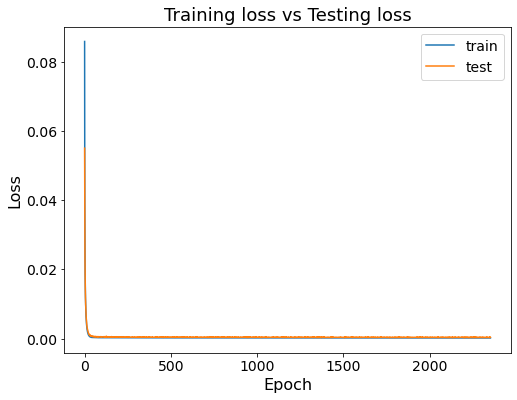

In [35]:
lr = 0.0001
EPOCHS = 8000

lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=5e-4, 
                                                          decay_steps=10000,
                                                          decay_rate=0.99)


ws_pararcnn.compile(
#               optimizer=Adam(learning_rate=lr, decay=lr/EPOCHS), 
              optimizer=Adam(learning_rate=lr_schedule),
#               optimizer='adam',
              loss='mse',
              metrics=['mae'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=1000)
mc = ModelCheckpoint('saved_model/ws_pararcnn_sc1_5layer_{}h.h5'.format(K), monitor='val_mae', mode='min', verbose=2, save_best_only=True)

history = ws_pararcnn.fit(train_X, train_y,
                    batch_size=512,
                    epochs=EPOCHS,
                    validation_data=(test_X, test_y),
                    verbose=2,
                    shuffle=True,
                       callbacks=[es, mc])

plt.rcParams["figure.figsize"] = (8, 6)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(fontsize=14)
plt.title("Training loss vs Testing loss", fontsize=18)
# plt.savefig('graph/rnn_loss.png', dpi=300)
plt.show()

In [36]:
# model_load.predict(test_input).shape

### Performance

In [37]:
from tensorflow.keras.models import load_model

saved_model = load_model('saved_model/ws_pararcnn_sc1_5layer_{}h.h5'.format(K))

In [38]:
yhat = saved_model.predict(test_X)
inv_yhat = scaler.inverse_transform(yhat)
inv_y = scaler.inverse_transform(test_y)

inv_yhat = pd.DataFrame(inv_yhat)
inv_y = pd.DataFrame(inv_y)
print("inv_y.shape, inv_yhat.shape", inv_y.shape, inv_yhat.shape)

inv_y.shape, inv_yhat.shape (19268, 96) (19268, 96)


In [39]:
# inv_y

In [40]:
# inv_yhat

In [41]:
print('MAE = {}'.format(float("{:.4f}".format(mae(inv_yhat.iloc[:, :], inv_y.iloc[:, :])))))
print('RMSE = {}'.format(float("{:.4f}".format(sqrt(mse(inv_yhat.iloc[:, :], inv_y.iloc[:, :]))))))

MAE = 0.0541
RMSE = 0.0749
